# 20/11/2025 - Master Thesis Update

In [25]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from lonboard import PathLayer, Map
from IPython.display import Image, display

In [26]:
duckdb.sql("INSTALL spatial; LOAD spatial;")

In [22]:
con = duckdb.connect()
duckdb.install_extension("spatial", connection=con)
duckdb.load_extension("spatial", connection=con)

query = """
CREATE OR REPLACE TEMP TABLE latest AS    
SELECT *
FROM (
SELECT osm_id as relation_id, unnest(list_transform(list_filter(members, x -> struct_extract(x, 'type') = 'way'), m -> struct_pack(m_id := format('{}/{}', m.type, m.id), geometry := ST_GeomFromWKB(m.geometry))), recursive := true)
FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/latest/*.parquet')
WHERE
    osm_type = 'relation'
    AND map_contains_entry(tags, 'type', 'route')
    AND map_contains_entry(tags, 'route', 'bicycle')
    AND bbox.xmin BETWEEN 2.95 AND 7.4
    AND bbox.xmax BETWEEN 2.95 AND 7.4
    AND bbox.ymin BETWEEN 50.68 AND 53.71
    AND bbox.ymax BETWEEN 50.68 AND 53.71
)
WHERE geometry IS NOT NULL
"""

con.execute(query)

In [24]:
layer = PathLayer.from_duckdb(con.table("latest"), con, width_min_pixels=1, auto_highlight=True)
map_ = Map(layer)
map_

Map(custom_attribution='', layers=(PathLayer(table=arro3.core.Table
+-------------+---------------+-----------…

## Overview 

***

## Activity-based view vs State-based view

As is, the ohsome-planet history dataset is **activity-based**, in the sense that each row represents a **change** to an OSM element (creation, modification (of tags or geom) or deletion). For this reason:

- A single relation may appear **multiple times** if it was edited many times
- After expanding validity into years (using generate_series() together with unnest()), an element may appear **multiple times in the same year**

For certain kinds of analysis, a state-based view, as opposed to an activity-based one, is necessary. Using a state-based view:
- **exactly one row per year**

# Ohsome history file high-level overview 

## Activity-based view

In [173]:
duckdb.sql("""
SELECT 
    COUNT(*) AS total_osm_edits,
    COUNT(*) FILTER (WHERE osm_type = 'node') AS total_node_edits,
    COUNT(*) FILTER (WHERE osm_type = 'way') AS total_way_edits,
    COUNT(*) FILTER (WHERE osm_type = 'relation') AS total_relation_edits
FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/history/*.parquet')
WHERE 
    bbox.xmin BETWEEN 2.95 AND 7.4
    AND bbox.xmax BETWEEN 2.95 AND 7.4
    AND bbox.ymin BETWEEN 50.68 AND 53.71
    AND bbox.ymax BETWEEN 50.68 AND 53.71;
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

total_osm_edits  total_node_edits  total_way_edits  total_relation_edits
0         61972388          18192776         39989687               3789925

The query returns:
- Total number of **changes** ever made in the Netherlands
- Number of nodes edits, way edits and relation edits
- Information derived from the raw edit history (activity-based perspective)

## State-based view

In [176]:
duckdb.sql("""
WITH expanded_validity AS (
    SELECT
        osm_id,
        osm_type,
        UNNEST(generate_series(EXTRACT('YEAR' FROM valid_from), LEAST(EXTRACT('YEAR' FROM valid_to), 2025))) AS year
    FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/history/*.parquet')
    WHERE 
        osm_type IN ('node', 'way', 'relation')
        AND bbox.xmin BETWEEN 2.95 AND 7.4
        AND bbox.xmax BETWEEN 2.95 AND 7.4
        AND bbox.ymin BETWEEN 50.68 AND 53.71
        AND bbox.ymax BETWEEN 50.68 AND 53.71
)
SELECT
    COUNT(DISTINCT osm_id) AS total_osm_elements,
    COUNT(DISTINCT osm_id) FILTER (WHERE osm_type = 'node') AS total_node_elements,
    COUNT(DISTINCT osm_id) FILTER (WHERE osm_type = 'way') AS total_way_elements,
    COUNT(DISTINCT osm_id) FILTER (WHERE osm_type = 'relation') AS total_relation_elements
FROM expanded_validity
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

total_osm_elements  total_node_elements  total_way_elements  \
0            20344926              6977000            13590003   

   total_relation_elements  
0                   236740

This query returns: 
- Count of **distinct osm_id** across all years
- Count of unique nodes, ways and relations that ever existed in the dataset
- Information was computed from a state-based representation of the history file, created by expanding each element version over the years it was valid.

## Activity-based: Evolution editing intensity in the Netherlands across years

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

year  osm_type  edits_per_year  relative_frequency
0   2005      node               3           30.000000
1   2005       way               7           70.000000
2   2006      node            3751           95.324015
3   2006       way             184            4.675985
4   2007      node         3663554           75.233516
..   ...       ...             ...                 ...
56  2024  relation          229197           14.309439
57  2024       way         1130025           70.550765
58  2025      node          165837           16.391348
59  2025  relation          131178           12.965648
60  2025       way          714720           70.643004

[61 rows x 4 columns]

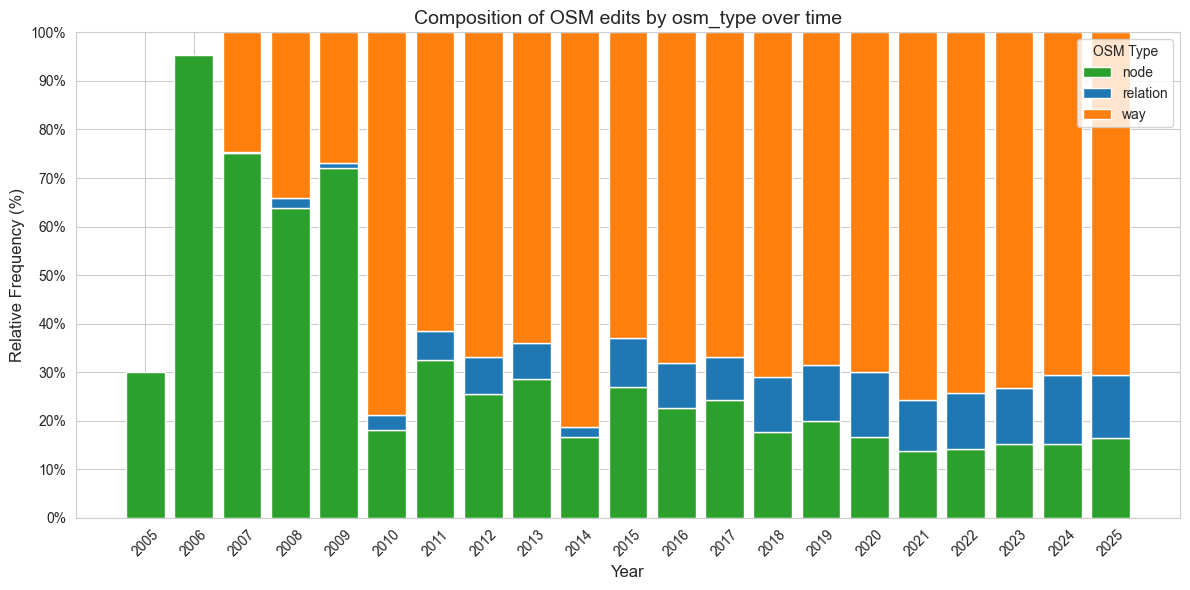

In [4]:
df = duckdb.sql("""
SELECT 
    EXTRACT(YEAR FROM valid_from) AS year,
    osm_type,
    COUNT(*) AS edits_per_year,
    COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY EXTRACT(YEAR FROM valid_from)) AS relative_frequency
FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/history/*.parquet')
WHERE
    osm_type IN ('node','way','relation')
    AND bbox.xmin BETWEEN 2.95 AND 7.4
    AND bbox.xmax BETWEEN 2.95 AND 7.4
    AND bbox.ymin BETWEEN 50.68 AND 53.71
    AND bbox.ymax BETWEEN 50.68 AND 53.71
GROUP BY year, osm_type
ORDER BY year, osm_type;
""").df()

display(df)

##Visualize results using a stacked bar chart 
#Prepare dataset for visualization (wide form required
df_pivot = df.pivot(index='year', columns='osm_type', values='relative_frequency')

# Ensure rows sum to 100 (optional, if they already do, skip)
df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

# Set style
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12,6))

#Assign a color to each osm_type. Relations blue
colors = {"node": "#2ca02c", "way": "#ff7f0e", "relation": "#1f77b4"}

#Define bottom
bottom = pd.Series([0]*len(df_pivot), index=df_pivot.index)
#Each osm_type should be plotted as a stacked bar chart
for col in df_pivot.columns:
    ax.bar(df_pivot.index, df_pivot[col], bottom=bottom, label=col, color=colors.get(col))
    bottom += df_pivot[col] 

#Design elements
ax.set_title('Composition of OSM edits by osm_type over time', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Relative Frequency (%)', fontsize=12)

#Y-axis formatting. Relative frequency up to 100
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 10))
ax.set_yticklabels([f"{y}%" for y in range(0, 101, 10)])

#X-axis formatting
ax.set_xticks(df_pivot.index)
ax.set_xticklabels(df_pivot.index, rotation=45)

#Add legend
ax.legend(title='OSM Type')
plt.tight_layout()
plt.show()

## State-based: Evolution composition OSM data in the Netherlands across years

Combining all years into a single count is not very informative, it only highlights how many unique OSM elements ever existed in the Netherlands, but nothing about when they existed.
Grouping by year gives a far more meaningful picture, as it allows to show how the number and composition of nodes, ways, and relations evolved over time.

By expanding each element across all the years it was valid (state-based view), it is possible to answer questions like:
- How many OSM elements were present in a given year?
- How did the share of nodes vs ways vs relations change over time?
- How rapidly did the OSM data grow each year?

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

year  osm_type  absolute_frequency  relative_frequency
0  2005      node                   3           30.000000
1  2005       way                   7           70.000000
2  2006      node                3754           95.912110
3  2006       way                 160            4.087890
4  2007      node             3598085           76.528866
5  2007  relation                 863            0.018355
6  2007       way             1102657           23.452778
7  2008      node             3949825           76.645328

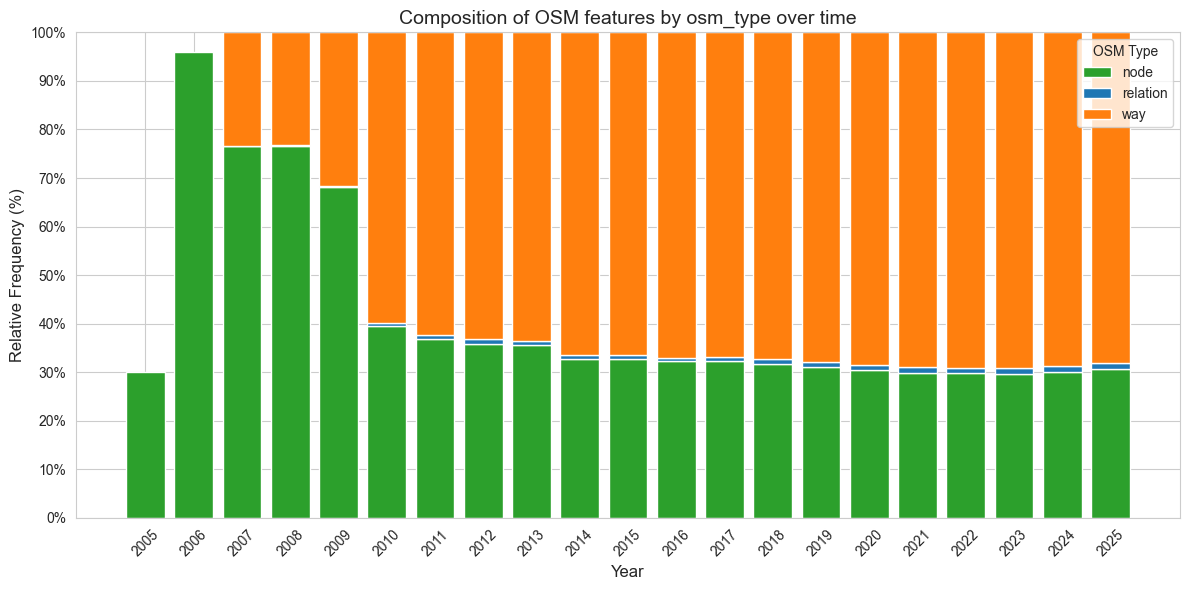

In [5]:
df = duckdb.sql("""
SELECT year, 
      osm_type,
      COUNT(DISTINCT osm_id) as absolute_frequency, --Count unique relations per year to avoid double-counting versions,
      COUNT(DISTINCT osm_id)*100.0/SUM(COUNT(DISTINCT osm_id)) OVER(PARTITION BY year) AS relative_frequency
FROM (
  SELECT * EXCLUDE members, 
        -- Expand each OSM relation's validity period into individual years 
        -- Generate one row per year the relation was valid (from valid_from to valid_to)
        unnest(generate_series(EXTRACT('YEAR' FROM valid_from), LEAST(EXTRACT('YEAR' FROM valid_to), 2025))) as year
  FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/history/*.parquet') -- history parquet file
  WHERE
    osm_type IN ('node', 'way', 'relation') -- Keep only relations. Each row in the history file represents a version (change) of a relation that existed at some point in time.
    AND bbox.xmin BETWEEN 2.95 AND 7.4 -- Filter to ensure data is within bounding box of the Netherlands
    AND bbox.xmax BETWEEN 2.95 AND 7.4
    AND bbox.ymin BETWEEN 50.68 AND 53.71
    AND bbox.ymax BETWEEN 50.68 AND 53.71
)
GROUP BY year, osm_type
ORDER BY year, osm_type;
""").df()

display(df.head(8))

##Visualize results using a stacked bar chart 
#Prepare dataset for visualization (wide form required
df_pivot = df.pivot(index='year', columns='osm_type', values='relative_frequency')

# Ensure rows sum to 100 (optional, if they already do, skip)
df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

# Set style
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12,6))

#Assign a color to each osm_type. Relations blue
colors = {"node": "#2ca02c", "way": "#ff7f0e", "relation": "#1f77b4"}

#Define bottom
bottom = pd.Series([0]*len(df_pivot), index=df_pivot.index)
#Each osm_type should be plotted as a stacked bar chart
for col in df_pivot.columns:
    ax.bar(df_pivot.index, df_pivot[col], bottom=bottom, label=col, color=colors.get(col))
    bottom += df_pivot[col] 

#Design elements
ax.set_title('Composition of OSM features by osm_type over time', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Relative Frequency (%)', fontsize=12)

#Y-axis formatting. Relative frequency up to 100
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 10))
ax.set_yticklabels([f"{y}%" for y in range(0, 101, 10)])

#X-axis formatting
ax.set_xticks(df_pivot.index)
ax.set_xticklabels(df_pivot.index, rotation=45)

#Add legend
ax.legend(title='OSM Type')
plt.tight_layout()
plt.show()

## State-based: Evolution total number of relations in Netherlands

year  total_relations_elements_per_year
0   2007                                863
1   2008                               4983
2   2009                              12466
3   2010                              63705
4   2011                              89052
5   2012                              97436
6   2013                             106444
7   2014                             118941
8   2015                             120501
9   2016                             122549
10  2017                             132017
11  2018                             138586
12  2019                             153408
13  2020                             171803
14  2021                             170599
15  2022                             168388
16  2023                             162511
17  2024                             150612
18  2025                             122140

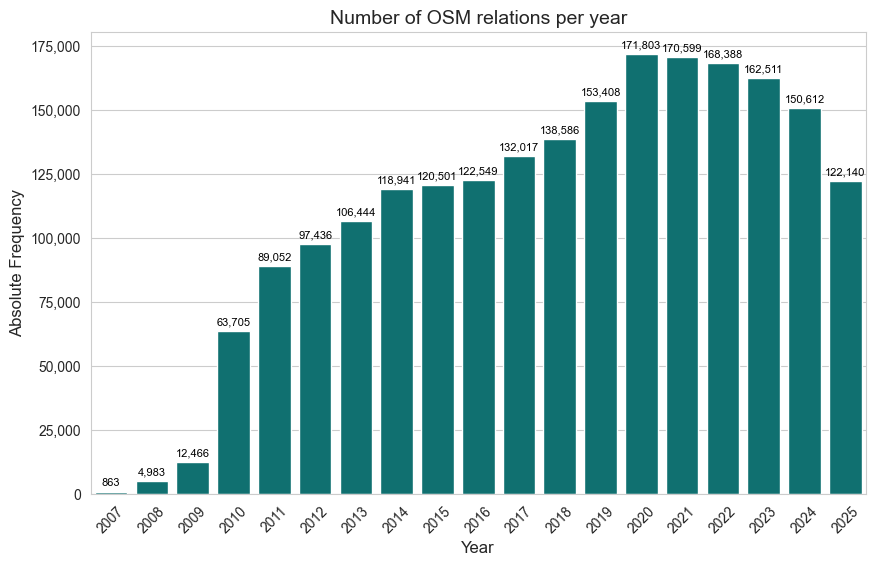

In [11]:
df_total_relations = duckdb.sql("""
SELECT year, 
      COUNT(DISTINCT osm_id) as total_relations_elements_per_year, --Count unique relations per year to avoid double-counting versions
FROM (
  SELECT * EXCLUDE members, 
        -- Expand each OSM relation's validity period into individual years 
        -- Generate one row per year the relation was valid (from valid_from to valid_to)
        unnest(generate_series(EXTRACT('YEAR' FROM valid_from), LEAST(EXTRACT('YEAR' FROM valid_to), 2025))) as year
  FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/history/*.parquet') -- history parquet file
  WHERE
    osm_type='relation' -- Keep only relations. Each row in the history file represents a version (change) of a relation that existed at some point in time.
    AND bbox.xmin BETWEEN 2.95 AND 7.4 -- Filter to ensure data is within bounding box of the Netherlands
    AND bbox.xmax BETWEEN 2.95 AND 7.4
    AND bbox.ymin BETWEEN 50.68 AND 53.71
    AND bbox.ymax BETWEEN 50.68 AND 53.71
)
GROUP BY year
ORDER BY year;
""").df()

display(df_total_relations)

##Visualize results using bar chart 
#Set style
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10,6))

sns.barplot(x='year', y='total_relations_elements_per_year', data=df_total_relations, color='teal', ax=ax)

#Design elements
ax.set_title('Number of OSM relations per year', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Absolute Frequency', fontsize=12)

#Add labels on top of bar showing absolute frequency
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:,.0f}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center', va='bottom',
        fontsize=8, color='black',
        xytext=(0, 3),
        textcoords='offset points'
)

#X-axis formatting
ax.set_xticks(range(len(df_total_relations['year'])))
ax.set_xticklabels(df_total_relations['year'], rotation=45)

#Y-axis formatting with thousands separator so easier to visually understand the number of relations
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.show()

## State-based/activity-based view: Persistent relations vs newly created relations

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

year  unique_total  unique_created  percent_created
0   2007           863             861        99.768250
1   2008          4983            4773        95.785671
2   2009         12466            8953        71.819349
3   2010         63705           55641        87.341653
4   2011         89052           69027        77.513138
5   2012         97436           65402        67.123035
6   2013        106444           63784        59.922588
7   2014        118941           66838        56.194248
8   2015        120501           38397        31.864466
9   2016        122549           23106        18.854499
10  2017        132017           25837        19.570964
11  2018        138586           27228        19.647006
12  2019        153408           34050        22.195713
13  2020        171803           38554        22.440819
14  2021        170599           30277        17.747466
15  2022        168388           24592        14.604366
16  2023        162511           21071        12.965892
17  2024        150612           16507        10.959950
18  2025        122140            8472         6.936303

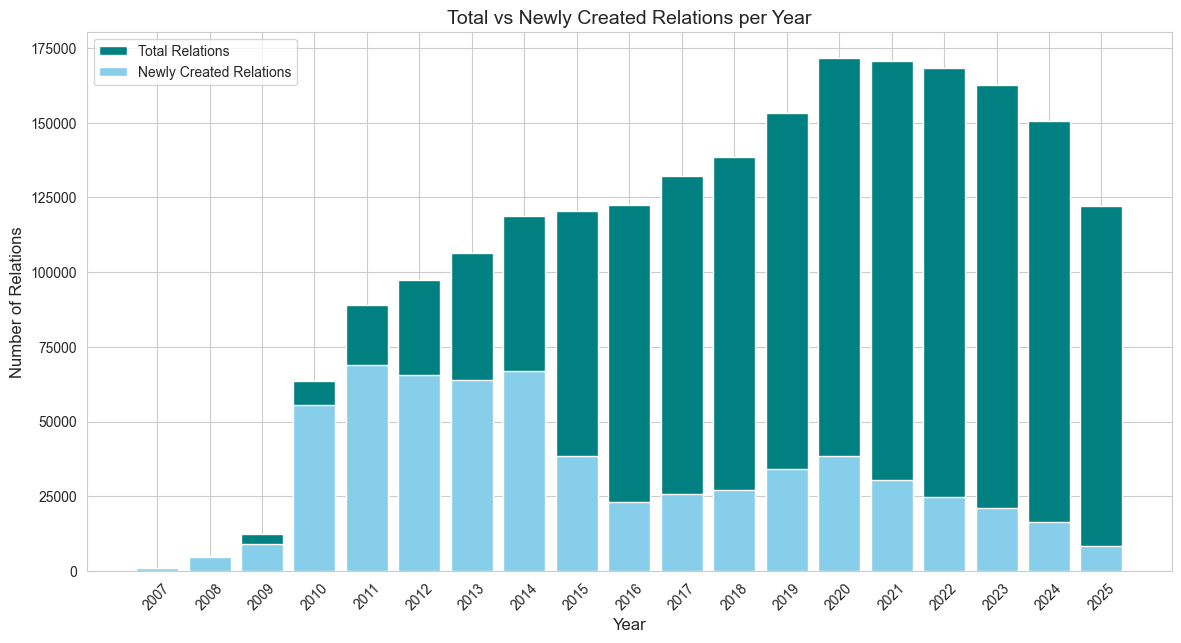

In [36]:
df = duckdb.sql("""
SELECT 
    year,
    COUNT(DISTINCT osm_id) AS unique_total,
    COUNT(DISTINCT CASE WHEN contrib_type = 'CREATION' THEN osm_id END) AS unique_created,
    COUNT(DISTINCT CASE WHEN contrib_type = 'CREATION' THEN osm_id END)*100.0/COUNT(DISTINCT osm_id) as percent_created
FROM (SELECT * EXCLUDE members,
            unnest(generate_series(EXTRACT('YEAR' FROM valid_from), LEAST(EXTRACT('YEAR' FROM valid_to), 2025))) AS year
    FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/history/*.parquet')
    WHERE osm_type='relation'
        AND bbox.xmin BETWEEN 2.95 AND 7.4
        AND bbox.xmax BETWEEN 2.95 AND 7.4
        AND bbox.ymin BETWEEN 50.68 AND 53.71
        AND bbox.ymax BETWEEN 50.68 AND 53.71
        )
GROUP BY year
ORDER BY year;
""").df()

display(df)

#Visalize total bicycle relations vs newly created bicycle relations
fig, ax = plt.subplots(figsize=(14,7))

ax.bar(df['year'], df['unique_total'], label='Total Relations', color='teal')
ax.bar(df['year'], df['unique_created'], label='Newly Created Relations', color='skyblue')

#Design elements
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Relations', fontsize=12)
ax.set_title('Total vs Newly Created Relations per Year', fontsize=14)
ax.set_xticks(df['year'])
ax.set_xticklabels(df['year'], rotation=45)
ax.legend()
plt.show()

## State-based: Evolution in the number of bicycle relations across years

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

year  absolute_frequency  relative_frequency
0   2007                  38            4.403244
1   2008                2957           59.341762
2   2009                4793           38.448580
3   2010                8109           12.728985
4   2011               10577           11.877330
5   2012               11512           11.814935
6   2013               12081           11.349630
7   2014               12685           10.664952
8   2015               13196           10.950946
9   2016               13577           11.078834
10  2017               14702           11.136445
11  2018               14784           10.667744
12  2019               15406           10.042501
13  2020               15761            9.173879
14  2021               15417            9.036981
15  2022               14985            8.899090
16  2023               14160            8.713256
17  2024               12289            8.159376
18  2025                7645            6.259211

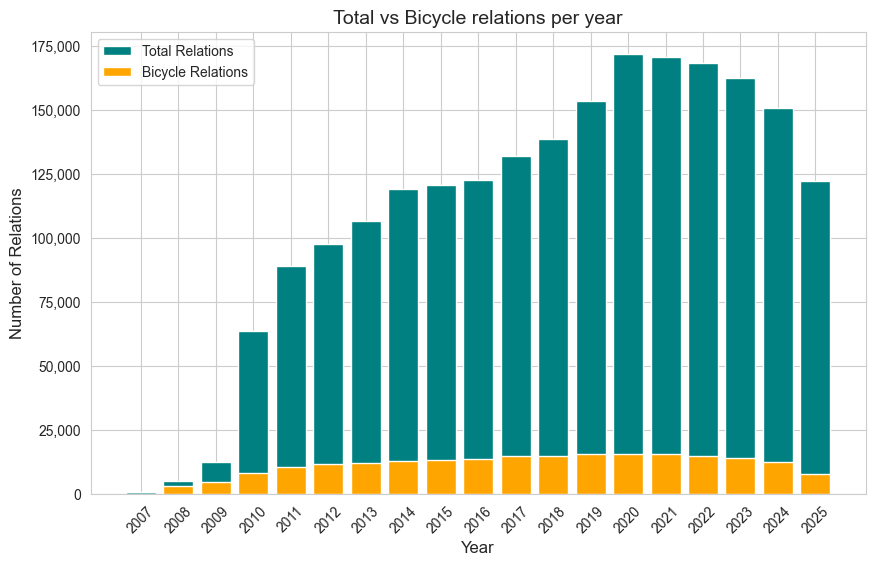

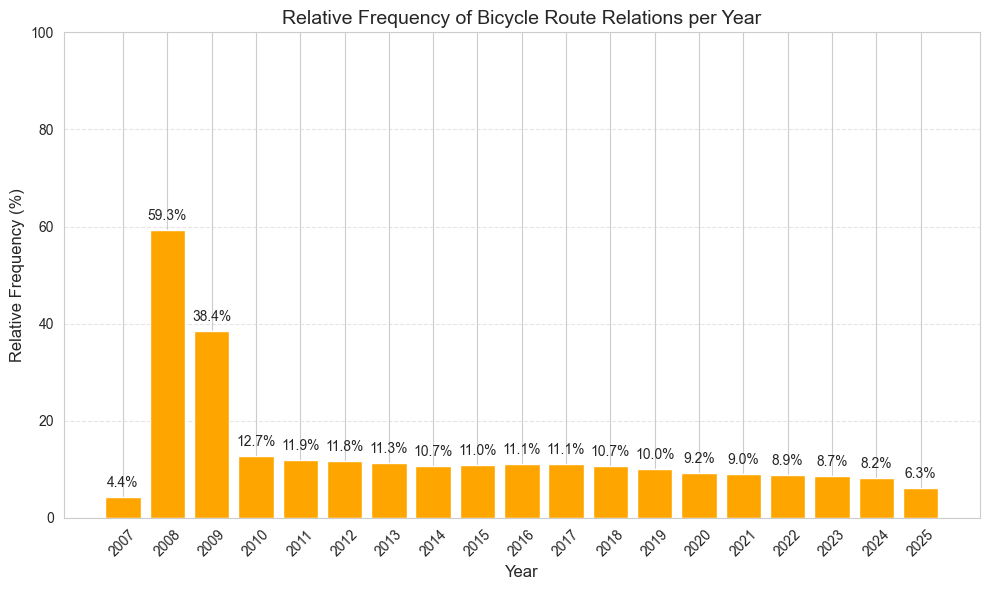

In [38]:
df = duckdb.sql("""
---#EVOLUTION: Evolution count of bicycle relations
WITH yearly_all_relations AS (
SELECT year, 
      COUNT(DISTINCT osm_id) as total_relations, --multiple rows per unique osm_id per year (do not want to double-count)
FROM (
  SELECT *,
        -- Expand each OSM relation's validity period into individual years 
        -- Generate one row per year the relation was valid (from valid_from to valid_to)
        unnest(generate_series(EXTRACT('YEAR' FROM valid_from), LEAST(EXTRACT('YEAR' FROM valid_to), 2025))) as year
  FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/history/*.parquet') -- history parquet file
  WHERE
    osm_type='relation' -- Keep only relations. Each row in the history file represents a version (change) of a relation that existed at some point in time.
    AND bbox.xmin BETWEEN 2.95 AND 7.4 -- Limit the results to relations within the bounding box of the Netherlands
    AND bbox.xmax BETWEEN 2.95 AND 7.4
    AND bbox.ymin BETWEEN 50.68 AND 53.71
    AND bbox.ymax BETWEEN 50.68 AND 53.71
)
GROUP BY year
ORDER BY year
),
yearly_bicycle_relations AS (
SELECT year, 
      COUNT(DISTINCT osm_id) as absolute_frequency, 
FROM (
  SELECT *,
        -- Expand each OSM relation's validity period into individual years 
        -- Generate one row per year the relation was valid (from valid_from to valid_to)
        unnest(generate_series(EXTRACT('YEAR' FROM valid_from), LEAST(EXTRACT('YEAR' FROM valid_to), 2025))) as year
  FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/history/*.parquet') -- history parquet file
  WHERE
    osm_type='relation' -- Keep only relations. Each row in the history file represents a version (change) of a relation that existed at some point in time.
    AND map_contains_entry(tags, 'type', 'route') --Select only relations versions tagged as type=route and route=bicycle
    AND map_contains_entry(tags, 'route', 'bicycle') 
    AND bbox.xmin BETWEEN 2.95 AND 7.4 -- Limit the results to relations within the bounding box of the Netherlands
    AND bbox.xmax BETWEEN 2.95 AND 7.4
    AND bbox.ymin BETWEEN 50.68 AND 53.71
    AND bbox.ymax BETWEEN 50.68 AND 53.71
 )
 GROUP BY year
)
SELECT year, 
      a.absolute_frequency,
      a.absolute_frequency*100.0/b.total_relations AS relative_frequency
FROM yearly_bicycle_relations a
JOIN yearly_all_relations b
USING (year)
ORDER BY year ASC;
""").df()

display(df)

#Visualize share of bicycle relations relative to total relations
# Merge df (above query) with df_total_relations
df_combined = df_total_relations.merge(
    df[['year', 'absolute_frequency']], 
    on='year'
)

#Set style
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10,6))

x = df_combined['year']

# Plot total relations
ax.bar(df_combined['year'], df_combined['total_relations_elements_per_year'], label='Total Relations', color='teal')

# Plot bicycle relations
ax.bar(df_combined['year'], df_combined['absolute_frequency'], label='Bicycle Relations', color='orange')

#Design elements
ax.set_title('Total vs Bicycle relations per year', fontsize=14)
#Y-axis formatting
ax.set_ylabel('Number of Relations', fontsize=12)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
#X-axis formatting
ax.set_xlabel('Year', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=45)
ax.legend()

plt.show()

#Then, zoom in to explore relative frequency of bicycle relations. 
fig, ax = plt.subplots(figsize=(10,6))

ax.bar(df['year'], df['relative_frequency'], color='orange')

#Design elements
ax.set_title('Relative Frequency of Bicycle Route Relations per Year', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Relative Frequency (%)', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# X-axis formatting
ax.set_xticks(df['year'])
ax.set_xticklabels(df['year'], rotation=45)

# Y-axis formatting
ax.set_ylim(0, 100)  


#Annotate bars with values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:.1f}%',
        (p.get_x() + p.get_width()/2., height),
        ha='center', va='bottom',
        fontsize=10,
        xytext=(0,5),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

## State-based/activity-based view: Persistent bicycle relations vs newly created bicycle relations

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

year  unique_total  unique_created  percent_created
0   2007            38              33        86.842105
1   2008          2957            2378        80.419344
2   2009          4793            2540        52.993950
3   2010          8109            4405        54.322358
4   2011         10577            4042        38.214995
5   2012         11512            1934        16.799861
6   2013         12081            1323        10.951080
7   2014         12685            1371        10.808041
8   2015         13196            1322        10.018187
9   2016         13577            1122         8.263976
10  2017         14702            1816        12.352061
11  2018         14784            1090         7.372835
12  2019         15406            1296         8.412307
13  2020         15761             554         3.515005
14  2021         15417             538         3.489654
15  2022         14985             436         2.909576
16  2023         14160             485         3.425141
17  2024         12289             349         2.839938
18  2025          7645             357         4.669719

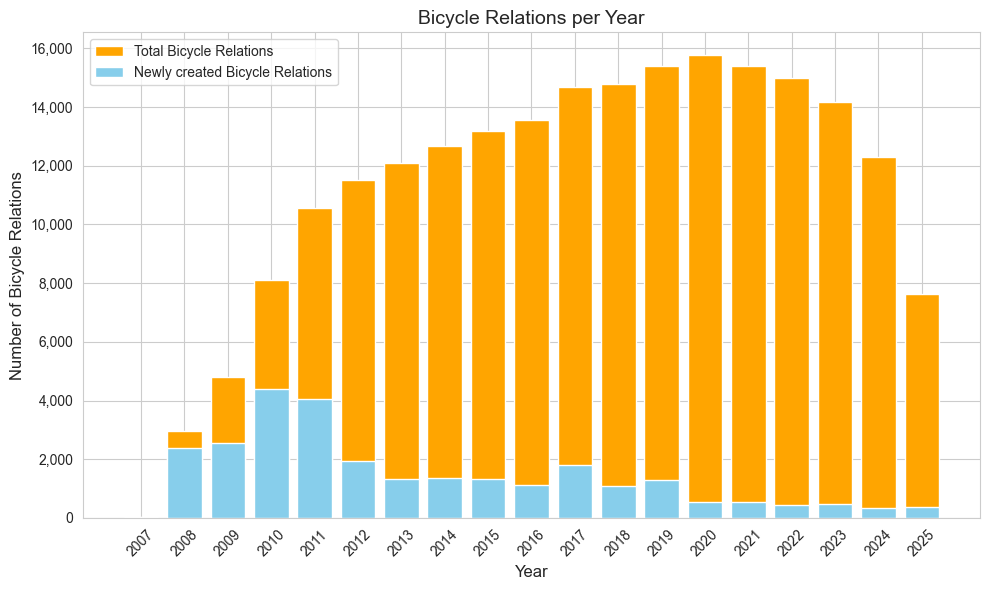

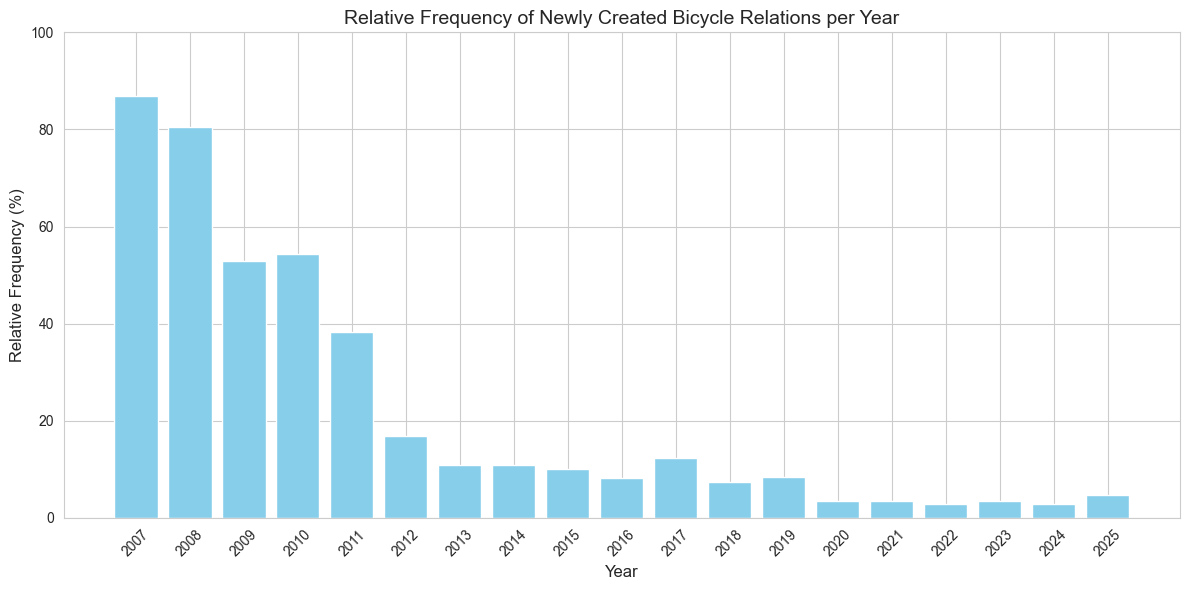

In [52]:
df = duckdb.sql("""
SELECT 
    year,
    COUNT(DISTINCT osm_id) AS unique_total,
    COUNT(DISTINCT CASE WHEN contrib_type = 'CREATION' THEN osm_id END) AS unique_created,
    COUNT(DISTINCT CASE WHEN contrib_type = 'CREATION' THEN osm_id END)*100.0/COUNT(DISTINCT osm_id) as percent_created
FROM (SELECT * EXCLUDE members,
            unnest(generate_series(EXTRACT('YEAR' FROM valid_from), LEAST(EXTRACT('YEAR' FROM valid_to), 2025))) AS year
    FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/history/*.parquet')
    WHERE osm_type='relation'
        AND map_contains_entry(tags, 'type', 'route')
        AND map_contains_entry(tags, 'route', 'bicycle')
        AND bbox.xmin BETWEEN 2.95 AND 7.4
        AND bbox.xmax BETWEEN 2.95 AND 7.4
        AND bbox.ymin BETWEEN 50.68 AND 53.71
        AND bbox.ymax BETWEEN 50.68 AND 53.71
        )
GROUP BY year
ORDER BY year;
""").df()

display(df)

#Visalize total bicycle relations vs newly created bicycle relations
fig, ax = plt.subplots(figsize=(10,6))

ax.bar(df['year'], df['unique_total'], label='Total Bicycle Relations', color='orange')
ax.bar(df['year'], df['unique_created'], label='Newly created Bicycle Relations', color='skyblue')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Bicycle Relations', fontsize=12)
ax.set_title('Bicycle Relations per Year', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(df['year'], rotation=45)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.legend()
plt.tight_layout()
plt.show()


#Visualize relative frequency of newly created bicycle relations separatedly 
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(df['year'], df['percent_created'], color='skyblue')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Relative Frequency (%)', fontsize=12)
ax.set_title('Relative Frequency of Newly Created Bicycle Relations per Year', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(df['year'], rotation=45)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

# State-based view: Appeareance of bicycle relations of type node_network

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

year  node_network_count  total_bicycle_count  \
0   2007                   0                   38   
1   2008                   0                 2957   
2   2009                   0                 4793   
3   2010                   0                 8109   
4   2011                   0                10577   
5   2012                   0                11512   
6   2013                   0                12081   
7   2014                   0                12685   
8   2015                   0                13196   
9   2016                   0                13577   
10  2017                   0                14702   
11  2018                   0                14784   
12  2019                 570                15406   
13  2020               14810                15761   
14  2021               14870                15417   
15  2022               14479                14985   
16  2023               13639                14160   
17  2024               11814                12289   
18  2025                7199                 7645   

    node_network_relative_frequency  
0                          0.000000  
1                          0.000000  
2                          0.000000  
3                          0.000000  
4                          0.000000  
5                          0.000000  
6                          0.000000  
7                          0.000000  
8                          0.000000  
9                          0.000000  
10                         0.000000  
11                         0.000000  
12                         3.699857  
13                        93.966119  
14                        96.451969  
15                        96.623290  
16                        96.320621  
17                        96.134755  
18                        94.166122

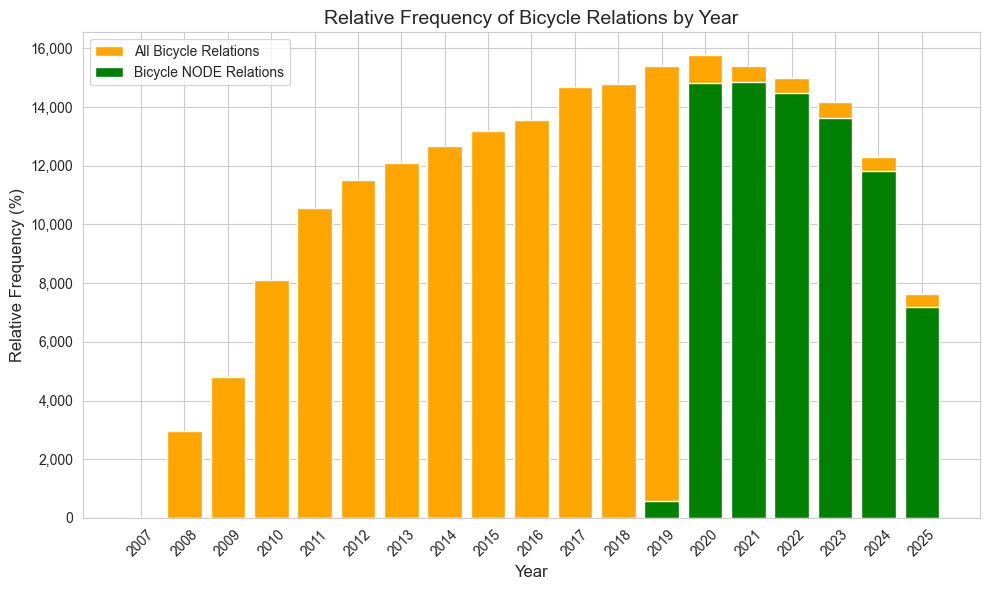

In [53]:
df = duckdb.sql("""
--##Method 2 - EVOLUTION: Evolution count of bicycle NODE RELATIONS relations relative to total BiCYLE relations over time  
WITH bicycle_relations AS (
  SELECT * EXCLUDE(members),
         unnest(generate_series(EXTRACT('YEAR' FROM valid_from), LEAST(EXTRACT('YEAR' FROM valid_to), 2025))) as year
  FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/history/*.parquet')
  WHERE osm_type='relation'
    AND map_contains_entry(tags, 'type', 'route')
    AND map_contains_entry(tags, 'route', 'bicycle')
    AND bbox.xmin BETWEEN 2.95 AND 7.4
    AND bbox.xmax BETWEEN 2.95 AND 7.4
    AND bbox.ymin BETWEEN 50.68 AND 53.71
    AND bbox.ymax BETWEEN 50.68 AND 53.71
)
SELECT year,
       COUNT(DISTINCT CASE WHEN map_contains_entry(tags, 'network:type', 'node_network') 
                           AND map_contains(tags, 'network') 
                           AND map_contains(tags, 'ref') 
                     THEN osm_id END) AS node_network_count,
       COUNT(DISTINCT osm_id) AS total_bicycle_count,
       COUNT(DISTINCT CASE WHEN map_contains_entry(tags, 'network:type', 'node_network') 
                           AND map_contains(tags, 'network') 
                           AND map_contains(tags, 'ref') 
                     THEN osm_id END)*100.0 / COUNT(DISTINCT osm_id) AS node_network_relative_frequency
FROM bicycle_relations
GROUP BY year
ORDER BY year;
""").df()

display(df)

#Visualize bicycle relations of type node vs total bicycle relations using barchart 
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(df['year'], df['total_bicycle_count'], label='All bicycle relations', color='orange')
ax.bar(df['year'], df['node_network_count'], label='Bicycle NODE relations', color='green')

#Design elements
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Relative Frequency (%)', fontsize=12)
ax.set_title('Relative Frequency of bicycle relations by year', fontsize=14)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.set_xticks(df['year'])
ax.set_xticklabels(df['year'], rotation=45)

ax.legend()
plt.tight_layout()
plt.show()

## Average number of members making up bicycle relations 

In [ ]:
df = duckdb.sql("""
--### EVOLUTION: Average number of MEMBERS making up bicycle relations 
WITH history_bicycle_relations AS (
SELECT osm_id, -- Unique ID of each relation in the dataset
      valid_from, 
      valid_to, --Necessary for 2nd CTE
      -- Count the total number of members (nodes, ways, and relations) that make up each bicycle relation. (i.e calculate length of the members struct column)
      length(members) as n_members, 
      -- Count how many of the members are ways: (i.e. calculate length of the filtered members struct column)
          -- 1. list_filter() keeps only members where the 'type' field equals 'way'
          -- 2. length() counts how many elements remain after filtering
      length(list_filter(members, x -> struct_extract(x, 'type') = 'way')) as n_way_members, 
      -- Count how many of the members are nodes:
      length(list_filter(members, x -> struct_extract(x, 'type') = 'node')) as n_node_members, 
      -- Count how many of the members are relations:
      length(list_filter(members, x -> struct_extract(x, 'type') = 'relation')) as n_relation_members,
      -- Expand each OSM relation's validity period into individual years 
      -- Generate one row per year the relation was valid (from valid_from to valid_to)
      unnest(generate_series(EXTRACT('YEAR' FROM valid_from), LEAST(EXTRACT('YEAR' FROM valid_to), 2025))) as year
FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/history/*.parquet') -- history parquet file
WHERE
  osm_type='relation' -- Keep only relations. Each row in the history file represents a version (change) of a relation that existed at some point in time.
  AND map_contains_entry(tags, 'type', 'route') --Select only relations versions tagged as type=route and route=bicycle
  AND map_contains_entry(tags, 'route', 'bicycle') 
  AND bbox.xmin BETWEEN 2.95 AND 7.4 -- Limit the results to relations within the bounding box of the Netherlands
  AND bbox.xmax BETWEEN 2.95 AND 7.4
  AND bbox.ymin BETWEEN 50.68 AND 53.71
  AND bbox.ymax BETWEEN 50.68 AND 53.71
), 
--Keep only the latest version per relation per year 
bicycle_relations_per_year AS (
  SELECT
    *,
    ROW_NUMBER() OVER ( -- Assign a rank to each relation version within the same relation-year group. The latest version (with the most recent valid_to date) will have rank = 1.
      PARTITION BY osm_id, year -- Group by relation and year to identify multiple versions of the same relation in a given year.
      ORDER BY valid_to DESC -- Order versions by valid_to so that the most recent one appears first.
    ) AS rn
  FROM history_bicycle_relations
)
--Select only the most recent version (goal:one record per relation per year)
SELECT year, 
        SUM(n_members) as total_members, 
        SUM(n_way_members) as way_members, 
        SUM(n_node_members) as node_members, 
        SUM(n_relation_members) as relation_members
FROM bicycle_relations_per_year
WHERE rn = 1 -- Keep only the latest version (rn = 1)
GROUP BY year
ORDER BY year;
""").df()

display(df)

#Visualize the results using a stacked bar chart 
#Prepare the dataset for visualization
#Convert dataset into long-format

# Set style
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12,6))

# Stacked bar plot
bottom = pd.Series([0]*len(df), index=df.index)
colors = {"node": "#2ca02c", "way": "#ff7f0e", "relation": "#1f77b4"}

for col in df.columns:
    ax.bar(df.index, df[col], bottom=bottom, label=col, color=colors.get(col))
    bottom += df[col]

#Design elements
ax.set_title('Composition of bicycle relation members over time', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Relative Frequency (%)', fontsize=12)

ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 10))
ax.set_yticklabels([f"{y}%" for y in range(0, 101, 10)])

ax.set_xticks(df_pivot.index)
ax.set_xticklabels(df_pivot.index, rotation=45)

ax.legend(title='Member Type')
plt.tight_layout()
plt.show()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

## Node_network type bicycle relation missing node members

- Total node network relations: 16,858
- Node network relations without member nodes: 16,239

Node network bicycle relations are expected to have **at least two tags at the node level** representing junction points with _network_ref= (e.g. rcn=ref=) values. These node-level _network_ref= values should correspond to the ref= tag found at the relation level.

However, most network relations in the dataset report **zero member nodes**, which might suggest poor data quality.

But, this apparent issue is misleading:
- Nodes tagged with ref= are often **not directly listed** as members of the relation.
  This might be because mappers frequently add junction nodes inside the ways rather than listing them explicitly as relation members. As a
  result, the node-level ref= tags exist within the ways and do not appear in the relation’s members column.
- Instead, these nodes often appear **within the ways that are members of the relation**.

Therefore, a proper check requires recursion:
- Start from the relation.
- Access its member ways.
- Access nodes within those ways.
- Finally, check node-level tags (_network_ref=) against the relation-level reference.

In other words, determining if a node network relation is complete and correct requires traversing from relations → ways → member nodes, rather than relying solely on the members column at the relation level.

In [159]:
total_node_network_relations = duckdb.sql("""
SELECT COUNT(*) as total_node_network_relations
FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/latest/*.parquet') -- latest parquet file
WHERE
  osm_type='relation' 
  AND map_contains_entry(tags, 'type', 'route') --Select only relations versions tagged as type=route and route=bicycle
  AND map_contains_entry(tags, 'route', 'bicycle') 
  AND map_contains_entry(tags, 'network:type', 'node_network') 
  AND map_contains(tags, 'network')
  AND map_contains(tags, 'ref') 
  AND bbox.xmin BETWEEN 2.95 AND 7.4 -- Limit the results to relations within the bounding box of the Netherlands
  AND bbox.xmax BETWEEN 2.95 AND 7.4
  AND bbox.ymin BETWEEN 50.68 AND 53.71
  AND bbox.ymax BETWEEN 50.68 AND 53.71
""").df()

df = duckdb.sql("""
SELECT COUNT(*) as node_network_without_nodes
FROM (
SELECT list_filter(members, x -> struct_extract(x, 'type') = 'node') as node_members
FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/latest/*.parquet') -- latest parquet file
WHERE
  osm_type='relation' 
  AND map_contains_entry(tags, 'type', 'route') --Select only relations versions tagged as type=route and route=bicycle
  AND map_contains_entry(tags, 'route', 'bicycle') 
  AND map_contains_entry(tags, 'network:type', 'node_network') 
  AND map_contains(tags, 'network')
  AND map_contains(tags, 'ref') 
  AND bbox.xmin BETWEEN 2.95 AND 7.4 -- Limit the results to relations within the bounding box of the Netherlands
  AND bbox.xmax BETWEEN 2.95 AND 7.4
  AND bbox.ymin BETWEEN 50.68 AND 53.71
  AND bbox.ymax BETWEEN 50.68 AND 53.71
)
WHERE length(node_members) < 2;
""").df()

display(total_node_network_relations) 
display(df)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

total_node_network_relations
0                         16858

node_network_without_nodes
0                       16239

# Prepatarion - RELATION-LEVEL: TAG-ANALYSIS

---

**The goal of this section is to explore how tags on bicycle relations have evolved over time.**

---

Similar to the high-level analysis of relations, the study of relation tags can be approached from two conceptual perspectives, activity-based or state-based, each addressing different types of questions

In this tag analysis I will take a **state-based** perspective and to do this the ohsome planet dataset needs to be transformed. 

#### **Activity-Based View (as provided by the raw ohsome-planet history dataset)**

The **ohsome-planet history dataset is inherently activity-based:**
- Each row corresponds to **one change event** to an OSM element
(creation, deletion, tag modification, geometry modification).
- A single relation may therefore appear **many times**, one for each edit made to it.
- Tag values in the dataset represent the state after that specific edit.
- If a bicycle relation was edited 30 times over the years, it will appear 30 times in the history dataset.

Below is an example showing how bicycle relations appear in the raw history dataset:

In [61]:
df = duckdb.sql("""
SELECT *    
    FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/history/*.parquet')
    WHERE osm_type='relation'
        AND map_contains_entry(tags, 'type', 'route')
        AND map_contains_entry(tags, 'route', 'bicycle')
        AND bbox.xmin BETWEEN 2.95 AND 7.4
        AND bbox.xmax BETWEEN 2.95 AND 7.4
        AND bbox.ymin BETWEEN 50.68 AND 53.71
        AND bbox.ymax BETWEEN 50.68 AND 53.71
LIMIT 100;
""").df()


display(df.head())

status                valid_from                  valid_to  osm_type  \
0  history 2008-01-09 11:46:15+01:00 2008-06-25 21:40:39+02:00  relation   
1  history 2008-06-25 21:40:39+02:00 2009-12-11 18:11:47+01:00  relation   
2  history 2009-12-11 18:11:47+01:00 2010-01-11 21:13:01+01:00  relation   
3  history 2010-01-11 21:13:01+01:00 2010-01-11 21:13:51+01:00  relation   
4  history 2010-01-11 21:13:51+01:00 2010-05-31 20:37:39+02:00  relation   

   osm_id  osm_version  osm_minor_version  osm_edits  \
0    2757            2                  0          2   
1    2757            3                  0          3   
2    2757            3                  1          4   
3    2757            4                  0          5   
4    2757            6                  0          6   

              osm_last_edit                                user  ...  \
0 2007-10-30 12:32:53+01:00      {'id': 8943, 'name': 'Fopper'}  ...   
1 2008-01-09 11:46:15+01:00    {'id': 30059, 'name': 'itserik'}  ...   
2 2008-06-25 21:40:39+02:00    {'id': 26230, 'name': 'BugBlue'}  ...   
3 2009-12-11 18:11:47+01:00  {'id': 43967, 'name': 'railsnail'}  ...   
4 2010-01-11 21:13:01+01:00  {'id': 43967, 'name': 'railsnail'}  ...   

                                            geometry area area_delta length  \
0  [0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 5, 64, 28...  0.0        0.0    0.0   
1  [0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 5, 64, 28...  0.0        0.0    0.0   
2  [0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 5, 64, 28...  0.0        0.0    0.0   
3  [0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 5, 64, 28...  0.0        0.0    0.0   
4  [0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 5, 64, 28...  0.0        0.0    0.0   

  length_delta  contrib_type  refs  \
0          0.0      GEOMETRY  <NA>   
1          0.0           TAG  <NA>   
2          0.0  TAG_GEOMETRY  <NA>   
3          0.0           TAG  <NA>   
4          0.0           TAG  <NA>   

                                             members  countries  build_time  
0  [{'type': 'node', 'id': 45862814, 'role': 'sto...         []       50700  
1  [{'type': 'node', 'id': 45862814, 'role': 'sto...         []       35800  
2  [{'type': 'node', 'id': 45862814, 'role': 'sto...         []       42300  
3  [{'type': 'node', 'id': 45862814, 'role': 'sto...         []       33400  
4  [{'type': 'node', 'id': 45862814, 'role': 'sto...         []       33600  

[5 rows x 27 columns]

#### **Effect of Expanding Validity into Years**

To transform the dataset into a state-based format, each version’s validity range is expanded to all individual years it was valid using:
- generate_series()
- unnest()

## 1. Extract bicycle relations and expand validity into years 

In [3]:
duckdb.sql("""
CREATE OR REPLACE TEMP TABLE bicycle_relations AS 
    SELECT osm_id,
            valid_from,
            valid_to,
            tags,
            tags_before,
            contrib_type,
            --members, I get Out of Memory Allocation Failure
            unnest(generate_series(EXTRACT('YEAR' FROM valid_from), LEAST(EXTRACT('YEAR' FROM valid_to), 2025))) AS year
    FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/history/*.parquet')
    WHERE osm_type='relation'
        AND map_contains_entry(tags, 'type', 'route')
        AND map_contains_entry(tags, 'route', 'bicycle')
        AND bbox.xmin BETWEEN 2.95 AND 7.4
        AND bbox.xmax BETWEEN 2.95 AND 7.4
        AND bbox.ymin BETWEEN 50.68 AND 53.71
        AND bbox.ymax BETWEEN 50.68 AND 53.71;
"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

This expansion introduces a second source of duplication:
- A relation may appear **multiple times in the same year** if it was edited multiple times that year.
- Without additional processing, we **do not yet have one clean representation per element per year.**

This duplication is evident from the fact that COUNT(*) of bicycle relations ≠ COUNT(DISTINCT osm_id) of bicycle relations.

In [ ]:
df1 = duckdb.sql("""
SELECT year, COUNT(*) as total_changes_bicycle_relations
FROM bicycle_relations
GROUP BY year
ORDER BY year;
""").df()

df2 = duckdb.sql("""
SELECT year, COUNT(DISTINCT osm_id) as total_bicycle_relations
FROM bicycle_relations
GROUP BY year
ORDER BY year;
""").df() 

display(df1, df2)

After expanding, the bicycle relations table contains:
- **duplicate osm_id across years** (as expected)
- but also **duplicate osm_id within the same year** (multiple edits within the same year to the same relation).


### Quantify how much can tags change ? 

This duplication means that a single relation may have several tag versions within the same year.
To understand how frequently these within-year modifications happen, the following query measures **how often bicycle relations undergo tag changes in each year.**

High values = bicycle relations were **actively modified** that year.
Low values = relations were **stable**, with few tag updates.
The standard deviation highlights whether **many relations changed a little vs a few relations changed a lot.**

year  avg_changed_per_osm_id  std_changed_per_osm_id
0   2007                0.447368                0.497222
1   2008                0.338181                0.473090
2   2009                0.379303                0.485214
3   2010                0.325811                0.468677
4   2011                0.226718                0.418709
5   2012                0.127259                0.333262
6   2013                0.048258                0.214310
7   2014                0.023729                0.152203
8   2015                0.029251                0.168510
9   2016                0.024085                0.153313
10  2017                0.020065                0.140224
11  2018                0.011499                0.106615
12  2019                0.968324                0.175136
13  2020                0.704524                0.456257
14  2021                0.090485                0.286875
15  2022                0.038906                0.193370
16  2023                0.020339                0.141157
17  2024                0.014566                0.119807
18  2025                0.010726                0.103009

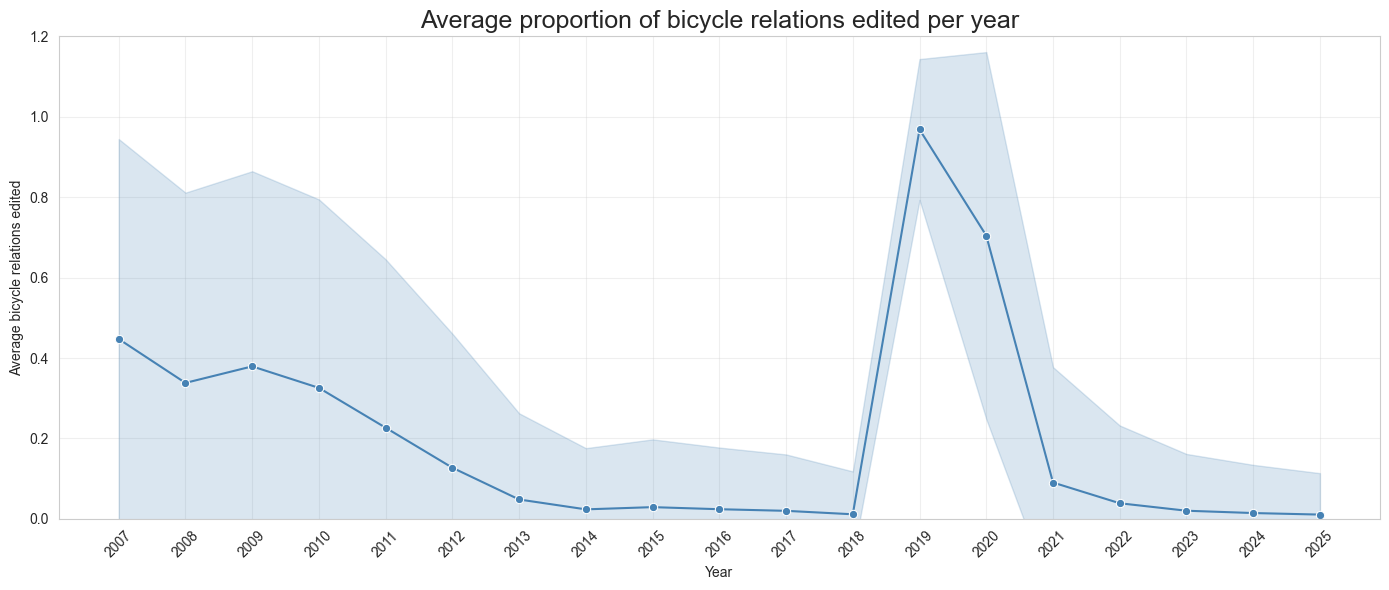

In [74]:
df = duckdb.sql("""
WITH osm_changes AS (
    SELECT
        year,
        osm_id,
        -- check if any record in the year is a change
        MAX(
            CASE
                WHEN tags_before IS NULL OR tags_before = '{}' THEN 0  -- ignore creation
                WHEN cardinality(tags) != cardinality(tags_before) THEN 1 -- length differs, then counted as change
                ELSE 0  -- otherwise, no change
            END
        ) AS changed_in_year
    FROM bicycle_relations
    GROUP BY year, osm_id
)
SELECT
    year,
    AVG(changed_in_year) AS avg_changed_per_osm_id,
    STDDEV_POP(changed_in_year) AS std_changed_per_osm_id
FROM osm_changes
GROUP BY year
ORDER BY year;
""").df()

display(df)

##Visualize average changes per year 
fig, ax = plt.subplots(figsize=(14,6))

sns.lineplot(
    data=df, 
    x='year', 
    y='avg_changed_per_osm_id', 
    marker='o', 
    color='steelblue',
    ax=ax
)

ax.fill_between(
    df['year'],
    df['avg_changed_per_osm_id'] - df['std_changed_per_osm_id'],
    df['avg_changed_per_osm_id'] + df['std_changed_per_osm_id'],
    color='steelblue',
    alpha=0.2
)


ax.set_xlabel("Year")
ax.set_ylabel("Average bicycle relations edited")
ax.set_title("Average proportion of bicycle relations edited per year", fontsize=18)
ax.set_xticks(df['year'])
ax.set_xticklabels([str(int(y)) for y in df['year']], rotation=45)
ax.set_ylim(0, 1.2)  
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Compute other per-year statistics on bicycle relation tags. 
The query below gives an insight into
- Did the tags on a bicycle relation change? (above results)
- How many tags were added or removed?
- The "net change"
- The ratio of tags added to tags removed 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

year  avg_changed_per_osm_id  std_changed_per_osm_id  avg_net_change  \
0   2007                0.447368                0.497222        2.506120   
1   2008                0.338181                0.473090        2.411930   
2   2009                0.379303                0.485214        1.462141   
3   2010                0.325811                0.468677        1.090579   
4   2011                0.226718                0.418709        0.663665   
5   2012                0.127259                0.333262        0.339046   
6   2013                0.048258                0.214310        0.273911   
7   2014                0.023729                0.152203        0.283173   
8   2015                0.029251                0.168510        0.250852   
9   2016                0.024085                0.153313        0.221016   
10  2017                0.020065                0.140224        0.349874   
11  2018                0.011499                0.106615        0.233920   
12  2019                0.968324                0.175136        0.467016   
13  2020                0.704524                0.456257        0.325712   
14  2021                0.090485                0.286875        0.097951   
15  2022                0.038906                0.193370        0.090983   
16  2023                0.020339                0.141157        0.115172   
17  2024                0.014566                0.119807        0.104574   
18  2025                0.010726                0.103009        0.174898   

    avg_keys_added  avg_keys_removed  add_remove_ratio  
0         5.500000          1.351351          4.070000  
1         5.153131          1.112545          4.631841  
2         4.742288          2.152275          2.203384  
3         4.234782          2.012455          2.104286  
4         4.101147          2.030703          2.019570  
5         4.121331          2.353950          1.750815  
6         4.030793          1.740620          2.315723  
7         4.001998          1.084855          3.688969  
8         4.176108          1.166570          3.579817  
9         4.223358          1.155192          3.655980  
10        4.242489          0.686133          6.183183  
11        4.327729          0.671875          6.441272  
12        5.048934          3.889995          1.297928  
13        5.128983          4.638749          1.105682  
14        5.245644          4.934955          1.062957  
15        5.253562          4.699812          1.117824  
16        5.300008          4.106778          1.290551  
17        5.388100          3.615233          1.490388  
18        5.476835          2.170277          2.523565

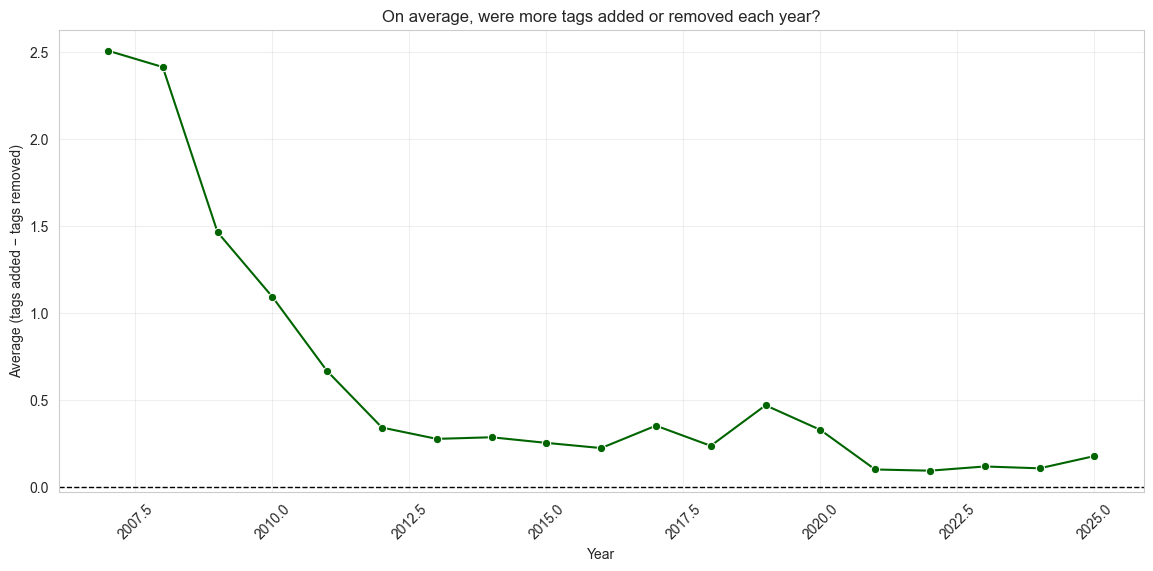

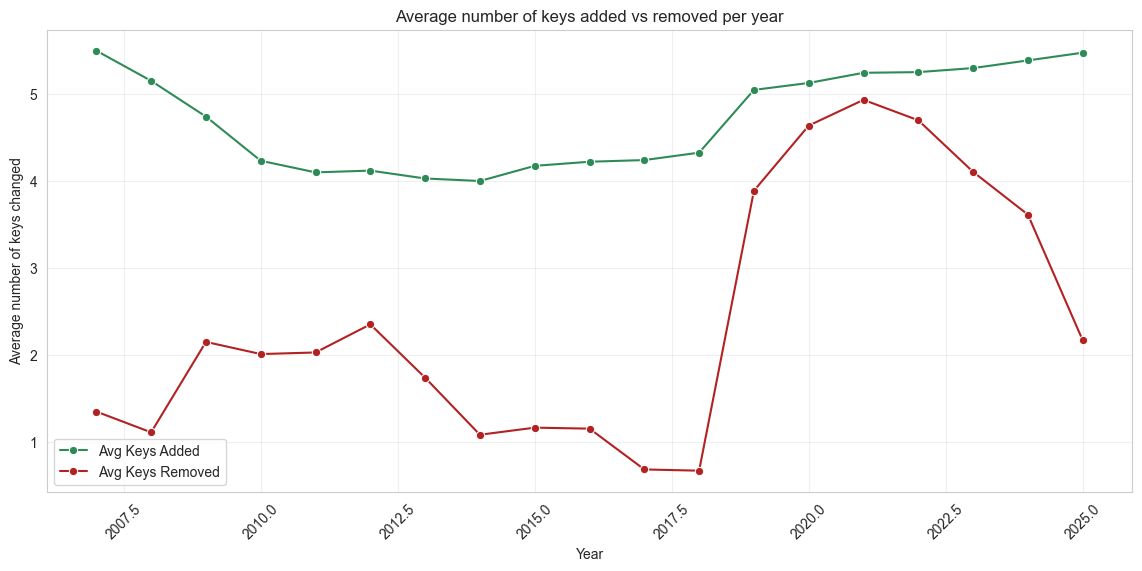

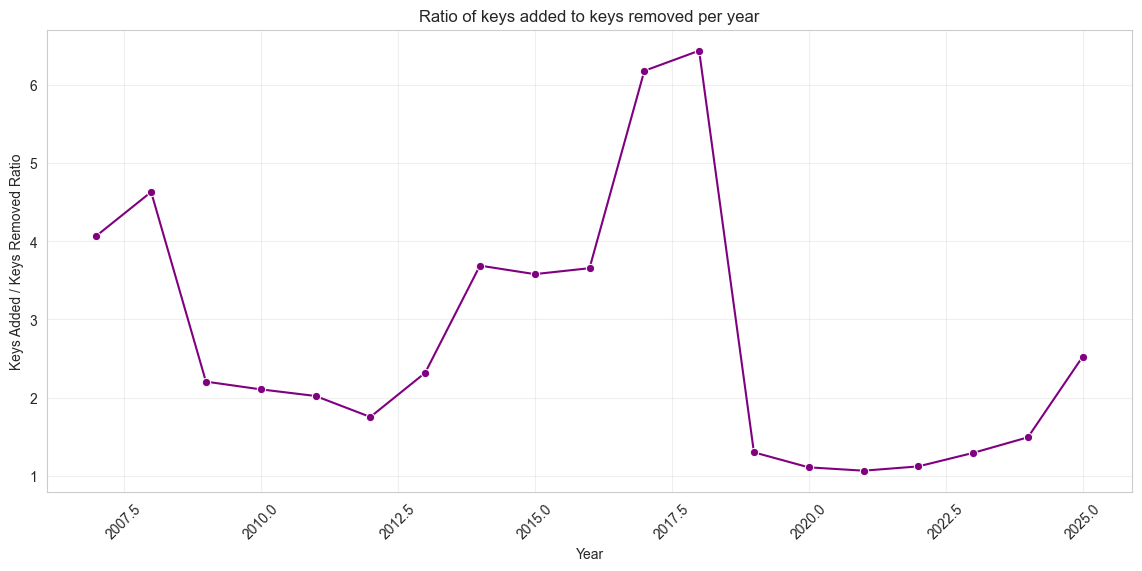

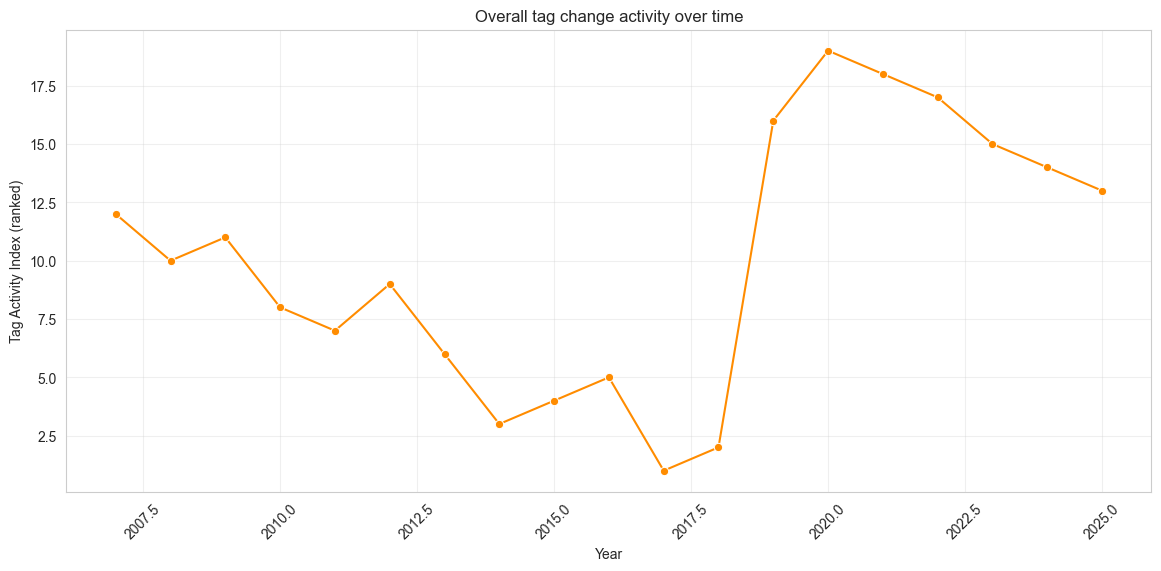

In [76]:
df = duckdb.sql("""
WITH tag_changes AS (
    SELECT
        year,
        osm_id,
        -- Did the set of tags change in size?
        MAX(
            CASE
                WHEN tags_before IS NULL OR tags_before = '{}' THEN 0  -- creation, ignore
                WHEN cardinality(tags) != cardinality(tags_before) THEN 1
                ELSE 0
            END
        ) AS changed_in_year,
        AVG(CAST(cardinality(tags) AS BIGINT) - CAST(cardinality(tags_before) AS BIGINT)) AS net_tag_enrichment,
        AVG(len((SELECT map_keys(tags) EXCEPT SELECT map_keys(tags_before)))) as n_keys_added,
        AVG(len((SELECT map_keys(tags_before) EXCEPT SELECT map_keys(tags)))) as n_keys_removed
    FROM bicycle_relations
    GROUP BY year, osm_id
)
SELECT
    year,
    AVG(changed_in_year) AS avg_changed_per_osm_id,
    STDDEV_POP(changed_in_year) AS std_changed_per_osm_id,
    AVG(net_tag_enrichment) AS avg_net_change,
    AVG(n_keys_added) AS avg_keys_added,
    AVG(n_keys_removed) AS avg_keys_removed,
    CASE 
        WHEN AVG(n_keys_removed) = 0 THEN NULL
        ELSE AVG(n_keys_added) / AVG(n_keys_removed)
    END AS add_remove_ratio
FROM tag_changes
GROUP BY year
ORDER BY year;
""").df()


display(df)

#Display whether, on average, more tags were added than removed each year  
plt.figure(figsize=(14,6))

sns.lineplot(
    data=df,
    x='year',
    y='avg_net_change',
    marker='o',
    color='darkgreen'
)

plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.xlabel("Year")
plt.ylabel("Average (tags added − tags removed)")
plt.title("On average, were more tags added or removed each year?")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()

#Display the average number of keys added vs keys removed per year
plt.figure(figsize=(14,6))

sns.lineplot(
    data=df, x='year', y='avg_keys_added', 
    marker='o', color='seagreen', label='Avg Keys Added'
)
sns.lineplot(
    data=df, x='year', y='avg_keys_removed', 
    marker='o', color='firebrick', label='Avg Keys Removed'
)

plt.xlabel("Year")
plt.ylabel("Average number of keys changed")
plt.title("Average number of keys added vs removed per year")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

#Display the ratio of keys added to keys removed
plt.figure(figsize=(14,6))

sns.lineplot(
    data=df,
    x='year',
    y='add_remove_ratio',
    marker='o',
    color='purple'
)

plt.xlabel("Year")
plt.ylabel("Keys Added / Keys Removed Ratio")
plt.title("Ratio of keys added to keys removed per year")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()


#Display how active tag editing was over time using a "tag-activity-index"
#Combine all changes into a single score to measure overall tag activity each year
df["tag_activity_index"] = (
      df["avg_changed_per_osm_id"]
    + df["avg_keys_added"]
    + df["avg_keys_removed"]
).rank()

plt.figure(figsize=(14,6))

sns.lineplot(
    data=df,
    x='year',
    y='tag_activity_index',
    marker='o',
    color='darkorange'
)

plt.xlabel("Year")
plt.ylabel("Tag Activity Index (ranked)")
plt.title("Overall tag change activity over time")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()


# 2. Relation-Level: Deduplicate to one version per relation per year

As shown above, modifications to bicycle relation tags occur **within a single year** and at varying rates.

Having those intra-year changes (i.e. rows for the same osm_id within a year) poses a problem for **state-based analysis**, because a proper representation requires:

- **Exactly one row per osm_id per year**

In the high-level counts, this was handled using DISTINCT, since only the number of relations mattered. However, the same approach **cannot** be used for tag-level analysis, because we need to decide **which version of the tags** represents the relation for that year.

DuckDB will throw an error with this query:

In [ ]:
## This will throw an error
duckdb.sql("""SELECT year, osm_id, tags
FROM bicycle_relations
GROUP BY year, osm_id
ORDER BY year;
""")

Binder Error: column "tags" must appear in the GROUP BY clause or must be part of an aggregate function.
Either add it to the GROUP BY list, or use "ANY_VALUE(tags)" if the exact value of "tags" is not important.
LINE 1: SELECT year, osm_id, tags

DuckDB is essentially saying: **"You have multiple possible tags for a single osm_id in a year. Which one should I choose?"**

Since the **exact tag values are important**, we cannot simply pick one arbitrarily. Therefore, a **clear strategy is needed** to determine which version of the tags to use for each relation per year.

## Why we must choose a single representative row per (osm_id, year)

##  Choosing a representative version

There are multiple strategies one could take (highlight pro and cons of each)

1. **Option 1: Latest version (end-of-year snapshot)**
    Use the version with the **latest** valid_to in that year
    This answers: What did the relation look like at the end of the year?
    Ultimately, it allows answering: What did the bicycle relation network look like at the end of the year?
3. **Option 2: Earliest version (start-of-year snapshot)**
   Use the versio with the **earliest** valid_from in that year.
   This answers: What did the relation look like at the start of the year?
   Ultimately, it allows answering: What did the bicycle relation network look like at the start of the year?
5. **Option 3: Snapshot at a specific date (e.g. 19 November)**
   Pick the version valid at a fixed date in each year (e.g., 19 November)
   This answers: What did the network look like on the same date every year?
   Ultimately, it allows answering: What did the bicycle relation network look like on the same date every year?
7. **Option 4: Longest lasting version**
    Pick the version that was valid the longest during that year
   This ansers: which version was most representative for that year?
   Ultimately, the resulting network may be somewhat artificial but will represent the version that dominated most of the year.
9. **Other?**
   - **Time-weighted strategies**:
     These methods consider how long each version existed within the year, instead of selecting a single “snapshot.”
     Possible approaches:
     - Weighted averaging of attributes (e.g. tag frequencies weighted by duration)
     - Probabilistic strategu, where versions valid longer have higher probability of representing the year.

For year-level analysis, we need **one row per osm_id per year**.  
- For simple counts (e.g., COUNT(*)), it is  enough to ensure **unique relations**, without picking a specific version.  
- For **tag-level analysis**, **member-relation analysis**, or **geometric analysis**, one must select **which version’s tags** represent that year.

A consistent, well-justified selection strategy is therefore essential for meaningful results.

## Choice: end-of-year snapshot (latest valid_to)

For each relation, I picked the row with the **latest valid_to within that year.** 

This gives:

- Only relations that still existed at the end of the year

Their final version in that year, regardless of how often they changed earlier
The motivation for choosing this method is simplicity at this early stage of the analysis.

In [4]:
duckdb.sql("""
--Keep relation with latest valid to (snapshot of tags at the end of the year)
CREATE OR REPLACE TEMP TABLE bicycle_relations_latest_valid_to AS 
SELECT *
FROM bicycle_relations
QUALIFY ROW_NUMBER() OVER (
    PARTITION BY osm_id, year 
    ORDER BY valid_to DESC --Keep row information with the latest valid_to
) = 1;
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

# RELATION-LEVEL: TAG-ANALYSIS

---

Based on the considerations above, the tag analysis will use the **table bicycle_relations_latest_valid_to** (refer to the earlier section for its construction).

### Relation-level: Creation of useful temporary tables for the analysis 

In [5]:
# Create a temporary table: total number of bicycle relations per year
duckdb.sql("""
CREATE OR REPLACE TEMP TABLE br_total_relations AS
SELECT 
    year, 
    COUNT(*) AS total_relations
FROM bicycle_relations_latest_valid_to
GROUP BY year;
""")

# Create a temporary table: unnested tags for bicycle relations across years
duckdb.sql("""
CREATE OR REPLACE TEMP TABLE br_unnested_tags AS
SELECT 
    *, 
    UNNEST(map_entries(tags), recursive := TRUE)  -- unnests all key-value pairs
FROM bicycle_relations_latest_valid_to;
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

## Average length of bicycle relation tags

year  avg_n_tags  median_n_tags  min_n_tags  max_n_tags  stddev_n_tags
0   2007    5.631579            6.0           4           7       0.750533
1   2008    5.201894            5.0           3           8       0.651445
2   2009    4.600459            4.0           3           8       0.701162
3   2010    4.261438            4.0           2          12       0.548100
4   2011    4.087548            4.0           2          12       0.373190
5   2012    4.065149            4.0           2          12       0.376895
6   2013    4.052231            4.0           2          18       0.518055
7   2014    4.055341            4.0           2          19       0.525535
8   2015    4.067899            4.0           2          18       0.528904
9   2016    4.079694            4.0           2          18       0.538703
10  2017    4.100599            4.0           2          18       0.594982
11  2018    4.105587            4.0           2          18       0.612955
12  2019    5.119759            5.0           2          22       0.650571
13  2020    5.120233            5.0           2          23       0.690084
14  2021    5.195434            5.0           2          24       0.948059
15  2022    5.195195            5.0           2          24       0.966747
16  2023    5.210028            5.0           2          25       1.007682
17  2024    5.232159            5.0           2          25       1.084584
18  2025    5.326880            5.0           2          25       1.331703

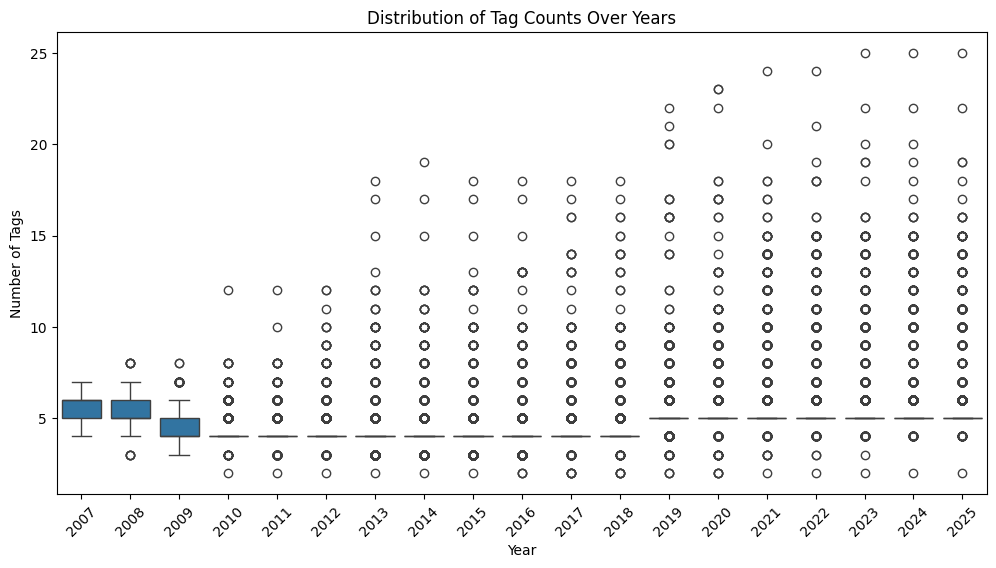

In [8]:
df = duckdb.sql("""
SELECT 
    year, 
    AVG(cardinality(tags)) AS avg_n_tags,       
    MEDIAN(cardinality(tags)) AS median_n_tags,
    MIN(cardinality(tags)) AS min_n_tags,  
    MAX(cardinality(tags)) AS max_n_tags, 
    STDDEV(cardinality(tags)) AS stddev_n_tags 
FROM bicycle_relations_latest_valid_to
GROUP BY year
ORDER BY year;
""").df()

display(df)

df_tags = duckdb.sql("""
SELECT 
    year, 
    cardinality(tags) AS tag_count
FROM bicycle_relations_latest_valid_to
""").df()

plt.figure(figsize=(12,6))

#Draw boxplot: x = year, y = tag_count (cardinality of tags per way)
sns.boxplot(x='year', y='tag_count', data=df_tags)

plt.title("Distribution of Tag Counts Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Tags")
plt.xticks(rotation=45)
plt.show()

## Evolution of 10 most frequent tags on bicycle relations (type=route, route=bicycle)

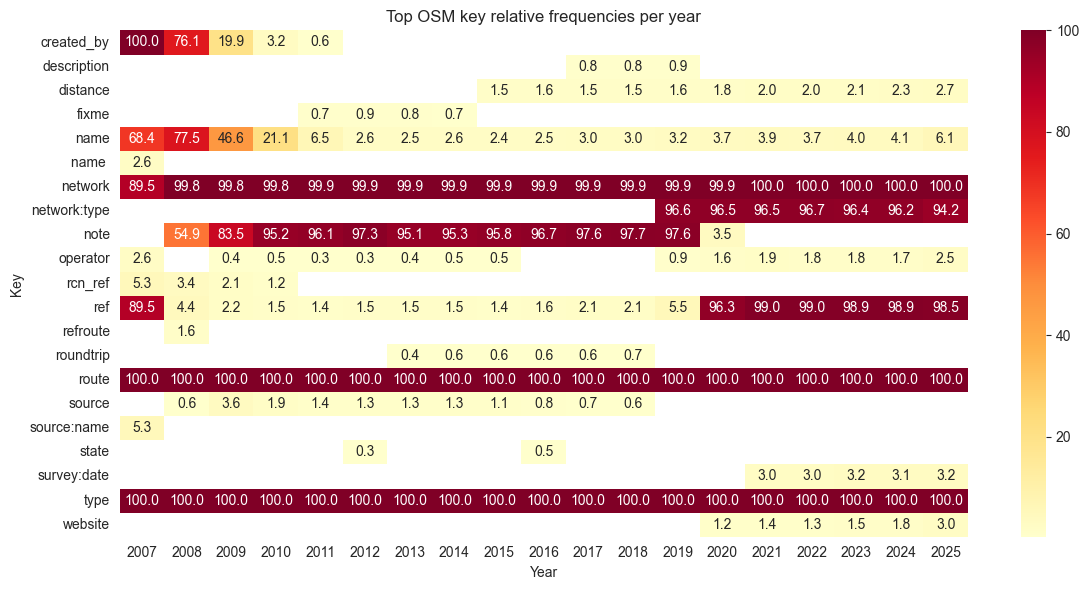

In [98]:
df = duckdb.sql("""
WITH key_frequencies_per_year AS (
    SELECT
        year,
        key,
        COUNT(*) AS absolute_frequency,
        COUNT(*) * 100.0 / total_relations AS relative_frequency
    FROM br_unnested_tags
    JOIN br_total_relations USING (year) -- join total number of relations per year
    GROUP BY year, key, total_relations
)
SELECT *
FROM key_frequencies_per_year
QUALIFY RANK() OVER (PARTITION BY year ORDER BY relative_frequency DESC) <= 10
ORDER BY year ASC, relative_frequency DESC;
""").df()

#Prepare dataset to create heatmap
heatmap_df = df.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(12, 6))

sns.set_style("white")
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Top OSM key relative frequencies per year")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()

## Evolution of 10 most frequent key:value pairs on bicycle relations (type=route, route=bicycle)

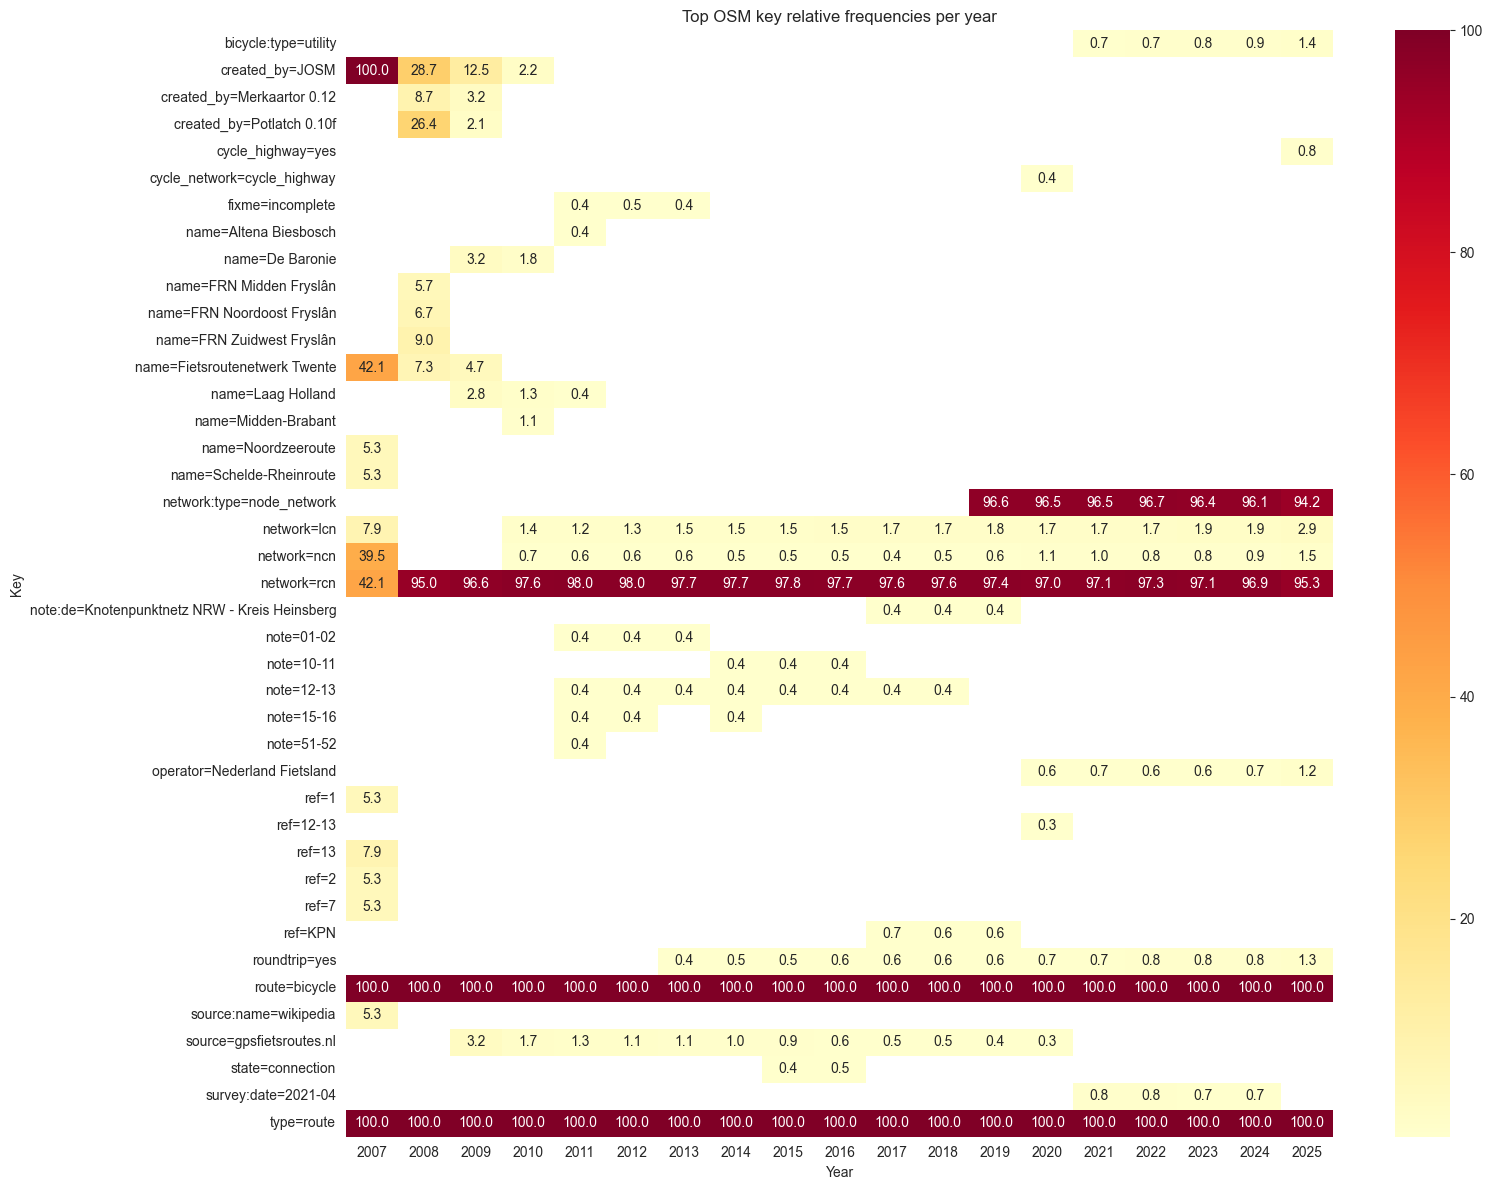

In [107]:
df = duckdb.sql("""
WITH key_frequencies_per_year AS (
    SELECT
        year,
        key || '=' || value as key_value,
        COUNT(*) AS absolute_frequency,
        COUNT(*) * 100.0 / total_relations AS relative_frequency
    FROM br_unnested_tags
    JOIN br_total_relations USING (year) -- join total number of relations per year
    GROUP BY year, key, value, total_relations
)
SELECT *
FROM key_frequencies_per_year
QUALIFY RANK() OVER (PARTITION BY year ORDER BY relative_frequency DESC) <= 10
ORDER BY year ASC, relative_frequency DESC;
""").df()

#Prepare dataset to create heatmap
heatmap_df = df.pivot(index="key_value", columns="year", values="relative_frequency")

plt.figure(figsize=(16, 12))

sns.set_style("white")
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Top OSM key relative frequencies per year")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()

## Explore most common keys amongst network=lcn, network=rcn, network=ncn, network=icn

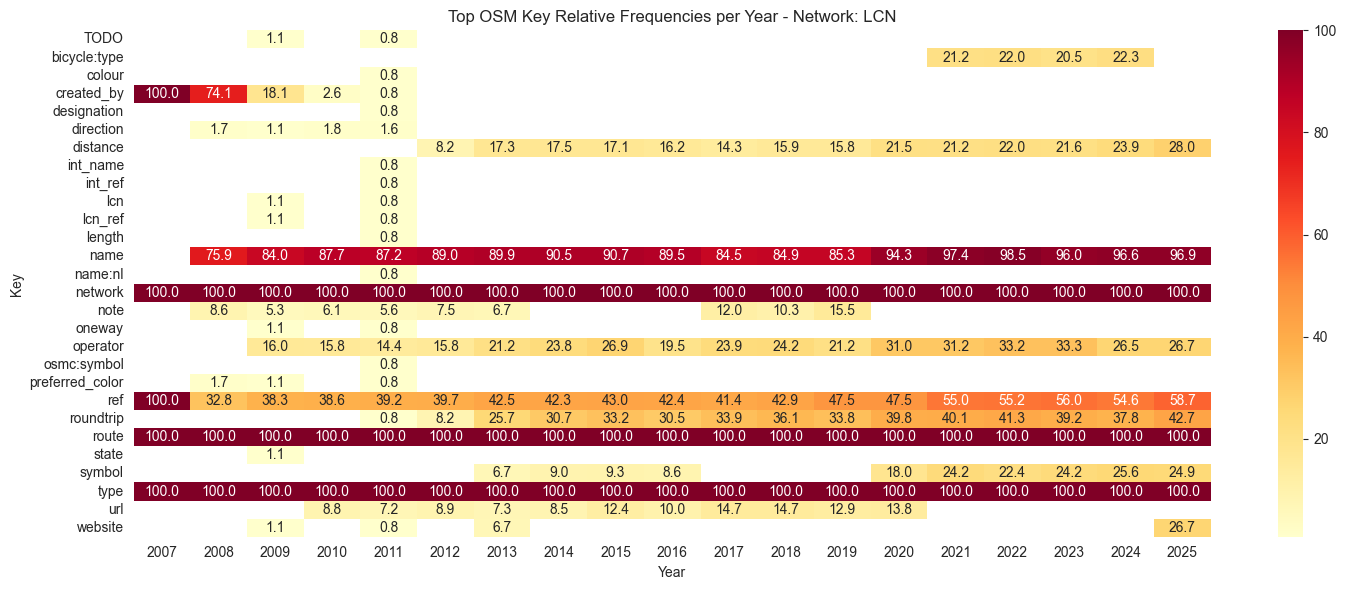

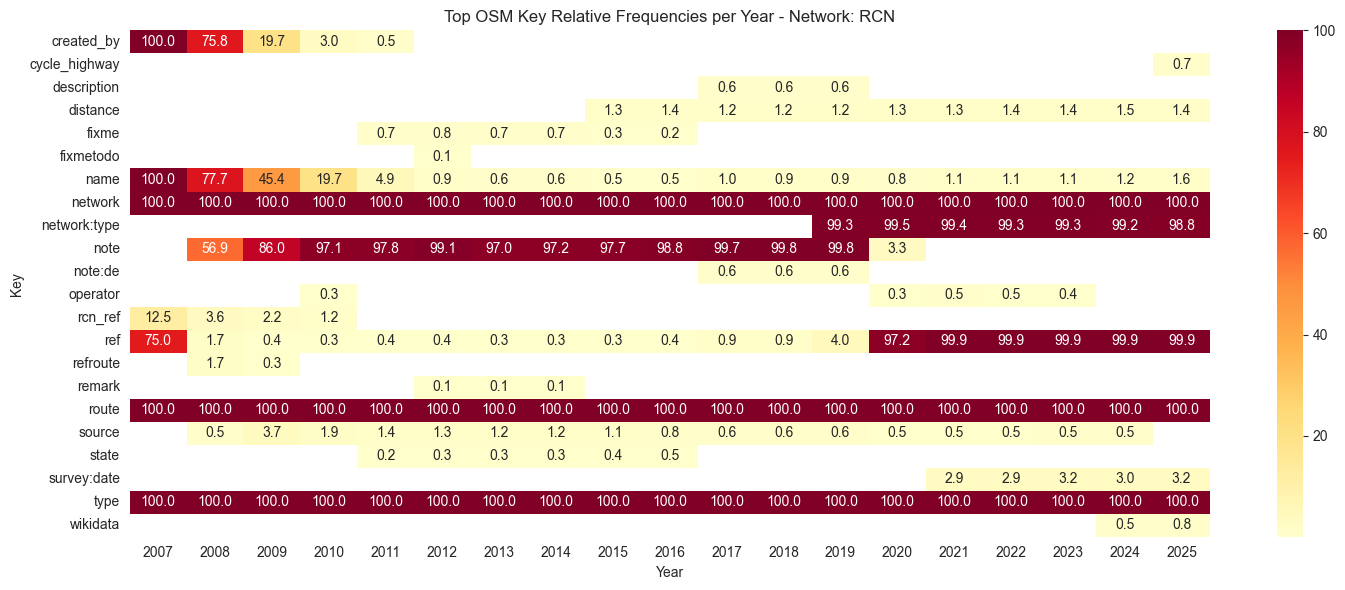

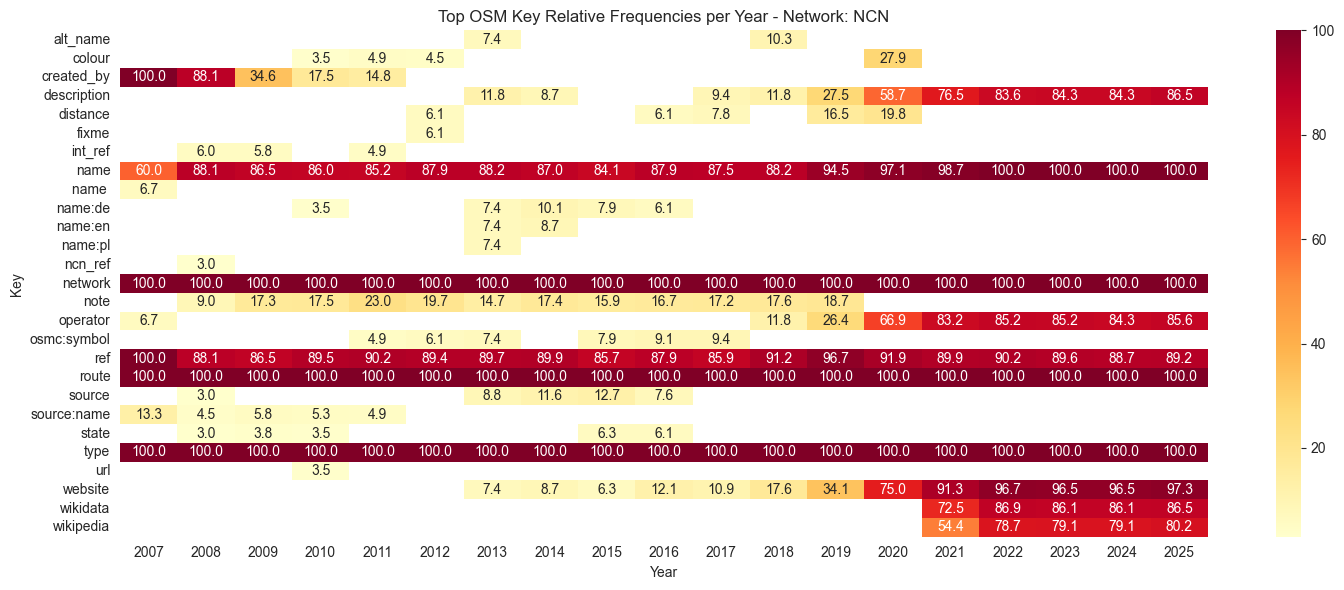

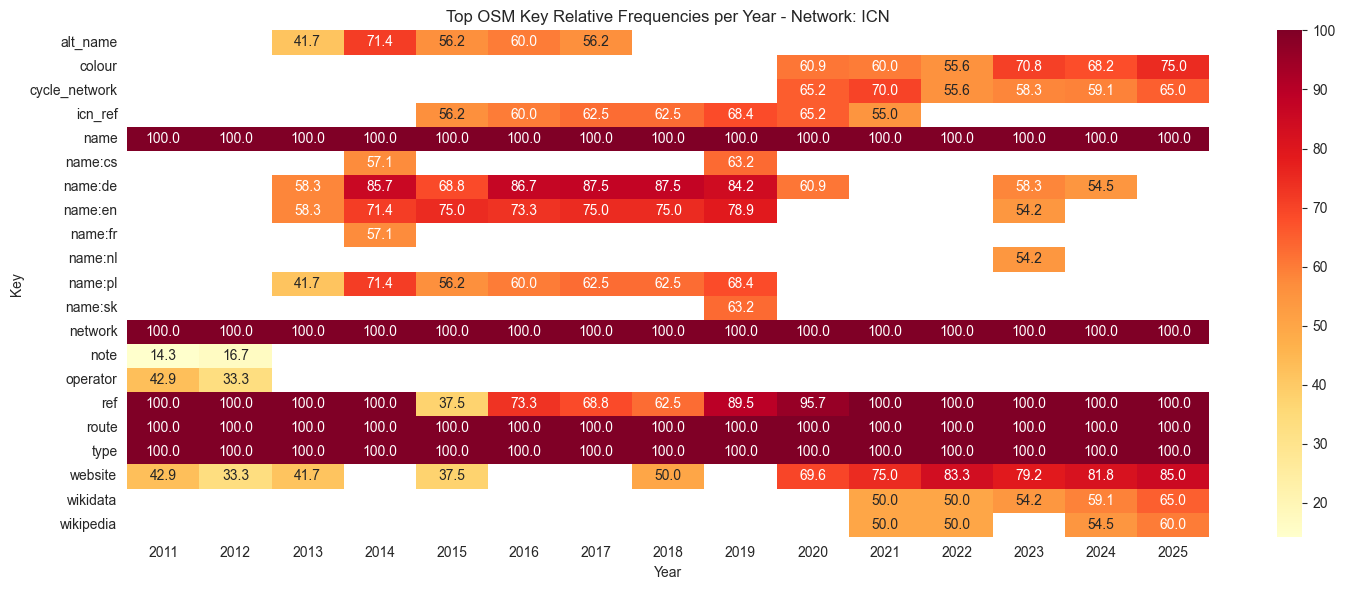

In [113]:
# Create a macro for bicycle relations similar to your previous one
df_bicycle_macro = duckdb.sql("""
CREATE OR REPLACE MACRO bicycle_network_analysis(filter_condition) AS TABLE (
    WITH br_unnested_tags_filtered AS (
        SELECT year, UNNEST(map_entries(tags), recursive := true)
        FROM bicycle_relations_latest_valid_to
        WHERE filter_condition
    ),
    total_br_filtered AS (
        SELECT year, COUNT(*) AS total_relations_filtered
        FROM bicycle_relations_latest_valid_to
        WHERE filter_condition
        GROUP BY year
    ),
    key_frequencies_per_year AS (
        SELECT
            year,
            key,
            COUNT(*) AS absolute_frequency,
            COUNT(*) * 100.0 / total_relations_filtered AS relative_frequency
        FROM br_unnested_tags_filtered
        JOIN total_br_filtered USING (year)
        GROUP BY year, key, total_relations_filtered
    )
    SELECT *
    FROM key_frequencies_per_year
    QUALIFY RANK() OVER (PARTITION BY year ORDER BY relative_frequency DESC) <= 10
    ORDER BY year ASC, relative_frequency DESC
);
""")

#Filter by network=lcn
df_lcn = duckdb.sql("""
SELECT * FROM bicycle_network_analysis(
    map_contains_entry(tags, 'network', 'lcn')
);
""").df()

#Filter by network=rcn, ncn, icn
df_rcn = duckdb.sql("""
SELECT * FROM bicycle_network_analysis(
    map_contains_entry(tags, 'network', 'rcn')
);
""").df()

#Filter by network=ncn
df_ncn = duckdb.sql("""
SELECT * FROM bicycle_network_analysis(
    map_contains_entry(tags, 'network', 'ncn')
);
""").df()

#Filter by network=icn
df_icn = duckdb.sql("""
SELECT * FROM bicycle_network_analysis(
    map_contains_entry(tags, 'network', 'icn')
);
""").df()


#Prepare data for heatmap - LCN
heatmap_df = df_lcn.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(15, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Top OSM Key Relative Frequencies per Year - Network: LCN")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()

#Prepare data for heatmap - RCN
heatmap_df = df_rcn.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(15, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Top OSM Key Relative Frequencies per Year - Network: RCN")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()

#Prepare data for heatmap - NCN
heatmap_df = df_ncn.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(15, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Top OSM Key Relative Frequencies per Year - Network: NCN")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()

#Prepare data for heatmap - ICN
heatmap_df = df_icn.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(15, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Top OSM Key Relative Frequencies per Year - Network: ICN")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()

# MEMBER WAY-LEVEL ANALYSIS: Bicycle Relations
---

## Why way-level information is essential for analysing bicycle relations

Bicycle relations (type=route + route=bicycle) **do not contain the infrastructure itself.**
They describe only the logical grouping of ways that form a cycling route.

But **relations do not tell you how bicycle-friendly the underlying infrastructure is.**

The infrastructure lives **entirely at the way level**, not at the relation level.

**Two bicycle relations can look identical at the relation level (e.g. same network type), but have completely different infrastructure quality depending on their member ways.**

## Accessing (bicycle) member information: latest vs history file

Accessing the **member ways** of bicycle relations is straightforward when working with the **latest** ohsome-planet parquet file. The same applies for node and relation members.

In the latest dataset:
- Each relation appears **once** (its current version).
- Members are stored directly in the **members** column.
- Joining member IDs with the ways table produces **exactly one match per member way.**

One can see this by examining this query: 

rm_ways_info = duckdb.sql("""
CREATE OR REPLACE TEMP TABLE rm_ways_info AS (
WITH rm_ways_ids AS (
SELECT unnest(list_apply(list_filter(members, x -> struct_extract(x, 'type') = 'way'), x -> struct_extract(x, 'id'))) as rm_ways_id
      FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/latest/*.parquet')
    WHERE
        osm_type = 'relation'
        AND map_contains_entry(tags, 'type', 'route')
        AND map_contains_entry(tags, 'route', 'bicycle')
        AND bbox.xmin BETWEEN 2.95 AND 7.4
        AND bbox.xmax BETWEEN 2.95 AND 7.4
        AND bbox.ymin BETWEEN 50.68 AND 53.71
        AND bbox.ymax BETWEEN 50.68 AND 53.71
    )
,
filtered_osm_ways AS (
    SELECT *
    FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/latest/*.parquet') 
    WHERE osm_type = 'way'
          AND bbox.xmin BETWEEN 2.95 AND 7.4
    AND bbox.xmax BETWEEN 2.95 AND 7.4
    AND bbox.ymin BETWEEN 50.68 AND 53.71
    AND bbox.ymax BETWEEN 50.68 AND 53.71
)
SELECT *
FROM filtered_osm_ways
INNER JOIN rm_ways_ids rm
ON filtered_osm_ways.osm_id = rm.rm_ways_id
); 
""")

The latest relations file contains a total of **294,432 member ways**, of which **217,350 are unique**. The duplicates are expected, because the same way can appear in multiple relations.

**Note:** the join returns only **183,033 ways**, fewer than the 217,350 unique IDs, because the remaining **34,317 ways** lie outside the Netherlands boundaries and therefore do not match any ways in the filtered dataset. This does _not_ break the one-to-one relationship.

display(Image(filename=r"C:\Users\Vanessa\Desktop\failed_join_image.png"))

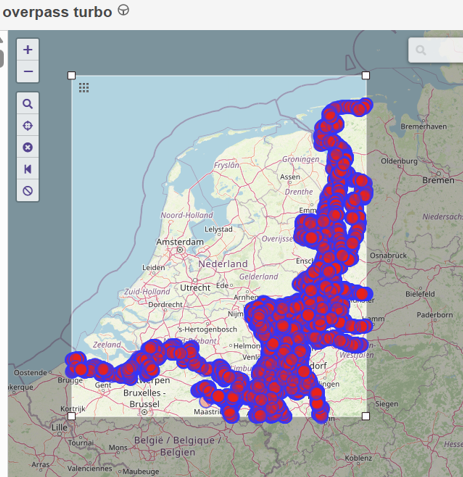

In [129]:
display(Image(filename=r"C:\Users\Vanessa\Desktop\failed_join_image.png"))

### **Why the same approach fails with the history file**

When switching to the **history parquet file**, the situation changes dramatically.

To reiterate, the history dataset is **activity-based**, meaning:
- Each row represents a **change event.**
- An OSM way appears **multiple times** (one per version).
- A relation appears **multiple times** (one per version).
- Member lists in relations correspond to what the relation looked like **at that moment** (when the edit is made), not globally over time.

Because of this, joining member IDs to the history ways table leads to:
**Problem: One member ID matches many rows**

A single way ID might have:
- 10 versions in the history file, representing all the changes the way presented throughout the lifespan of relation → the join produces 10 matches
- These versions may span several years
- They may have completely different tags and geometry

This is expected because the dataset captures **all edits**, not a final state.

### **Why this is this a challenge**

1. **Ambiguity in tag-level analysis**
    When joining relation-members to the history table, DuckDB asks:
    “Which version of the way do you want?”

Without choosing a strategy, several incosistencies arise, including ways are matched to ways outside the relation time span (for instance, it matched changes (versions) to ways that happened before or after the way became part of the relation)

A relation might include a way in 2015, but the way’s earliest version might be from 2007.
Without filtering, the join links relation-year 2015 to way-versions from 2007, 2009, 2012, 2015 and 2017. 
This inflates member data and distorts tag frequencies.

## Solution: keeping only the member versions valid during the relation's existence

To resolve the ambiguity, I **restricted the join** to only include way versions:
- whose validity **overlaps** with the relation-year,
- and then kept the **latest version** per way per year.

This gives a **state-based** representation of members for each year.

This is necessary because otherwise it is not possible to: 
- simply join on IDs (produces duplicates)
- simply use DISTINCT (destroys temporal meaning)
- simply use tags_before/tags (produces invalid year snapshots)

Instead, I chose to keep:
**For each member way and each year, the version with the latest valid_to.** (Same strategy I used for relations)

This creates:
- **one representative version per year**
- **consistent, comparable snapshots**
- **state-based member data**

In [126]:
for year in range(2007, 2026): 
    print(f"Creating table for year {year}...")
    duckdb.sql(f"""
    CREATE OR REPLACE TEMP TABLE rm_ways_{year} AS (
        WITH latest_relations AS (
            SELECT *
            FROM (
                SELECT *,
                       list_filter(generate_series(EXTRACT('YEAR' FROM valid_from), EXTRACT('YEAR' FROM valid_to)), x -> x = {year})[1] AS year
                FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/history/*.parquet')
                WHERE osm_type = 'relation'
                  AND map_contains_entry(tags, 'type', 'route')
                  AND map_contains_entry(tags, 'route', 'bicycle')
                  AND bbox.xmin BETWEEN 2.95 AND 7.4
                  AND bbox.xmax BETWEEN 2.95 AND 7.4
                  AND bbox.ymin BETWEEN 50.68 AND 53.71
                  AND bbox.ymax BETWEEN 50.68 AND 53.71
                  AND list_contains(generate_series(EXTRACT('YEAR' FROM valid_from), EXTRACT('YEAR' FROM valid_to)), {year})
            )
            QUALIFY ROW_NUMBER() OVER (PARTITION BY osm_id, year ORDER BY valid_to DESC) = 1  -- Keep latest version per relation per year
        ),
        rm_ways_ids_history AS (
            SELECT DISTINCT rm_ways_id, valid_from, valid_to, osm_id, year
            FROM (SELECT 
                osm_id,
                valid_from,
                valid_to,
                year,
                unnest(list_apply(list_filter(members, x -> struct_extract(x, 'type') = 'way'), x -> struct_extract(x, 'id'))) AS rm_ways_id
            FROM latest_relations
            )
        ),
        filtered_osm_ways AS (
            SELECT *
            FROM read_parquet('C:/Users/Vanessa/ohsome-planet/out-netherlands/contributions/history/*.parquet')
            WHERE osm_type = 'way'
              AND bbox.xmin BETWEEN 2.95 AND 7.4
              AND bbox.xmax BETWEEN 2.95 AND 7.4
              AND bbox.ymin BETWEEN 50.68 AND 53.71
              AND bbox.ymax BETWEEN 50.68 AND 53.71
        )
            SELECT
                rm.year,
                rm.osm_id AS relation_id,
                rm.rm_ways_id,
                w.tags,
                w.valid_from,
                w.valid_to,
                ST_GeomFromWKB(w.geometry) AS geom
            FROM filtered_osm_ways w
            JOIN rm_ways_ids_history rm
              ON w.osm_id = rm.rm_ways_id
             AND w.valid_from < rm.valid_to
             AND w.valid_to > rm.valid_from);
""")

Creating table for year 2007...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Creating table for year 2008...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Creating table for year 2009...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Creating table for year 2010...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Creating table for year 2011...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Creating table for year 2012...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Creating table for year 2013...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Creating table for year 2014...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Creating table for year 2015...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Creating table for year 2016...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Creating table for year 2017...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Creating table for year 2018...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Creating table for year 2019...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Creating table for year 2020...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Creating table for year 2021...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Creating table for year 2022...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Creating table for year 2023...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Creating table for year 2024...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Creating table for year 2025...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Similarly to what was done for bicycle_relations_latest_valid_to, in rm_from_relations_latest_valid_to there can be multiple entries for the same rm_ways_id within a year. Therefore, I selected only the version with the latest valid_to for each rm_ways_id per year

In [130]:
years = range(2007, 2026)

#Union all datasets constructed per year. Multiple constructed otherwise Out of Memory Errors 
union_query = " UNION ALL ".join([f"SELECT * FROM rm_ways_{year}" for year in years])

# Step 1: Create temp table with deduplicated rows directly from union - Keep rows with latest valid_to
temp_query = f"""
CREATE TEMP TABLE rm_ways AS
WITH all_years AS (
    {union_query}
)
SELECT *
FROM all_years
QUALIFY ROW_NUMBER() OVER (
    PARTITION BY year, rm_ways_id
    ORDER BY valid_to DESC
) = 1
ORDER BY rm_ways_id;
"""

duckdb.sql(temp_query)

# Step 2: Create persistent table from the temp table
persistent_query = """
CREATE OR REPLACE TABLE persistent_db.rm_from_relations_latest_valid_to AS
SELECT *
FROM rm_ways;
"""

duckdb.sql(persistent_query)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [117]:
duckdb.sql(r"ATTACH 'C:/Users/Vanessa/Desktop/ondisk_duckdb/ondisk_duckdb.duckdb' AS persistent_db")

## Count of bicycle relation member ways per year

Careful that the count increases over time not only because individual relations may have more member ways, but also because the number of bicycle relations themselves has increased.

year  total_rm_ways
0   2007            886
1   2008          33380
2   2009          54888
3   2010          84174
4   2011         108816
5   2012         122165
6   2013         131703
7   2014         135928
8   2015         139295
9   2016         143257
10  2017         148130
11  2018         148879
12  2019         149458
13  2020         147258
14  2021         139868
15  2022         121584
16  2023          94364
17  2024          55973
18  2025          22147

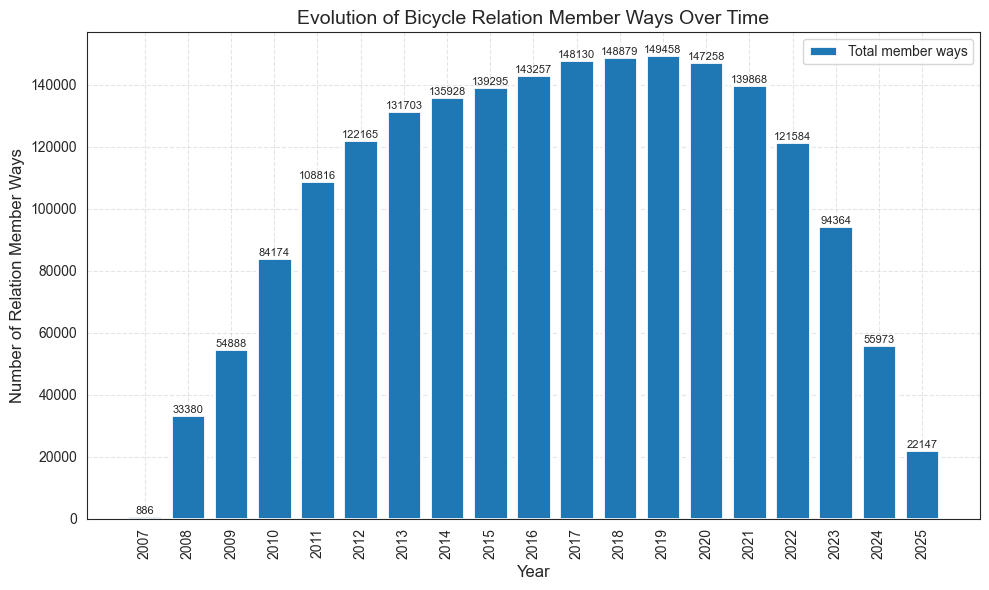

In [144]:
df = duckdb.sql("""
--## Goal: Show how the number of relation member ways changes over time
SELECT year,
    COUNT(*) as total_rm_ways
FROM persistent_db.rm_from_relations_latest_valid_to
GROUP BY year;
""").df()

display(df)

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(df['year'], df['total_rm_ways'], color='tab:blue', linewidth=2, label='Total member ways')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Relation Member Ways', fontsize=12)
ax.set_title('Evolution of Bicycle Relation Member Ways Over Time', fontsize=14)

for x, y in zip(df['year'], df['total_rm_ways']):
    ax.text(x, y, f'{y}', ha='center', va='bottom', fontsize=8)

ax.set_xticks(df['year'])
ax.set_xticklabels(df['year'], rotation=90) 
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()


### Creation of useful temporary tables

DuckDB does not support the creation of materialized views, so I created temporary tables

In [136]:
#Creation temporary table: total relation member ways per year 
duckdb.sql("""
CREATE OR REPLACE TEMP TABLE brm_total_ways AS
SELECT year, COUNT(*) as total_ways
FROM persistent_db.rm_from_relations_latest_valid_to
GROUP BY year
ORDER BY year
""")

#Creation of materialized view: unnested tags for relation member ways across years
duckdb.sql("""
CREATE OR REPLACE TEMP TABLE brm_ways_unnested_tags AS
SELECT *, UNNEST(map_entries(tags), recursive := true)
FROM persistent_db.rm_from_relations_latest_valid_to;
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

## Average length of bicycle relation tags

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

year  avg_tag_count  median_tag_count  min_tag_count  max_tag_count  \
0   2007       3.827314               4.0              1              9   
1   2008       3.957879               4.0              0             13   
2   2009       3.929420               4.0              0             13   
3   2010       3.833749               4.0              0             16   
4   2011       3.745010               4.0              0             18   
5   2012       3.603094               4.0              0             18   
6   2013       3.493056               3.0              0             21   
7   2014       2.965290               3.0              1             22   
8   2015       3.327133               3.0              0             17   
9   2016       3.627697               3.0              0             18   
10  2017       3.982610               3.0              0             24   
11  2018       4.122502               3.0              0             24   
12  2019       4.414511               4.0              1             25   
13  2020       4.824872               4.0              1             27   
14  2021       5.123852               4.0              1             27   
15  2022       5.464592               5.0              1             27   
16  2023       5.806981               5.0              1             27   
17  2024       6.223340               6.0              0             38   
18  2025       6.431300               6.0              1             38   

    stddev_tag_count  
0           1.099861  
1           1.142014  
2           1.257829  
3           1.337668  
4           1.520857  
5           1.599977  
6           1.622142  
7           1.564630  
8           1.905324  
9           2.129086  
10          2.352195  
11          2.414538  
12          2.533252  
13          2.698376  
14          2.787445  
15          2.880436  
16          2.965926  
17          3.014807  
18          2.975412

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

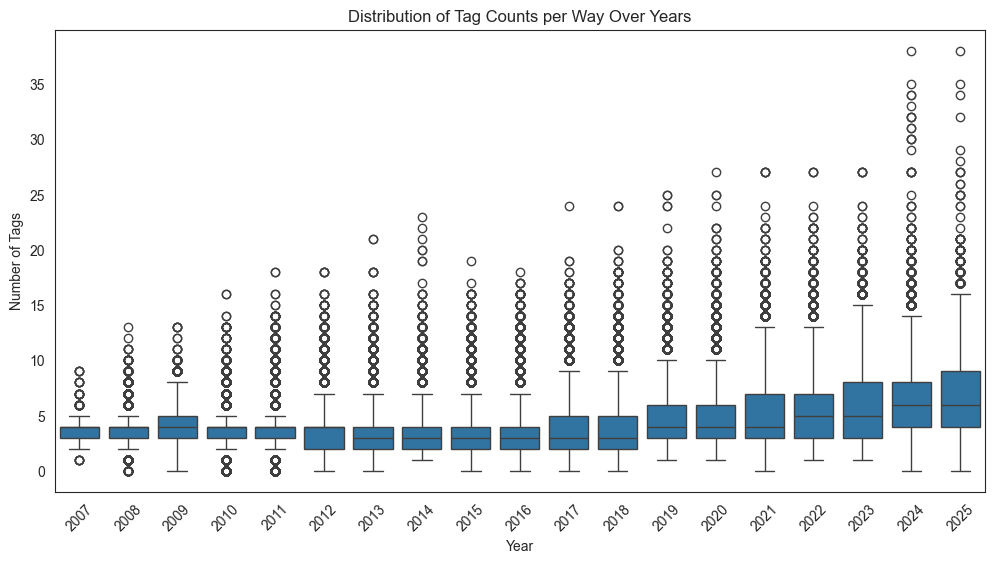

In [146]:
df = duckdb.sql("""
SELECT 
    year, 
    AVG(cardinality(tags)) AS avg_tag_count, -- Average number of tags per way
    MEDIAN(cardinality(tags)) AS median_tag_count, -- Median number of tags (robust to outliers)
    MIN(cardinality(tags)) AS min_tag_count, -- Minimum number of tags
    MAX(cardinality(tags)) AS max_tag_count, -- Maximum number of tags
    STDDEV(cardinality(tags)) AS stddev_tag_count -- Standard deviation of tags (how inconsistent/ varied tagging is)
FROM persistent_db.rm_from_relations_latest_valid_to
GROUP BY year
ORDER BY year;
""").df()

display(df)

df_tags = duckdb.sql("""
SELECT 
    year, 
    cardinality(tags) AS tag_count
FROM persistent_db.rm_ways_info_all
""").df()

plt.figure(figsize=(12,6))

#Draw boxplot: x = year, y = tag_count (cardinality of tags per way)
sns.boxplot(x='year', y='tag_count', data=df_tags)

plt.title("Distribution of Tag Counts per Way Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Tags")
plt.xticks(rotation=45)
plt.show()

## WAY-LEVEL: Evolution of 10 most frequent tags on bicycle relations (type=route, route=bicycle)

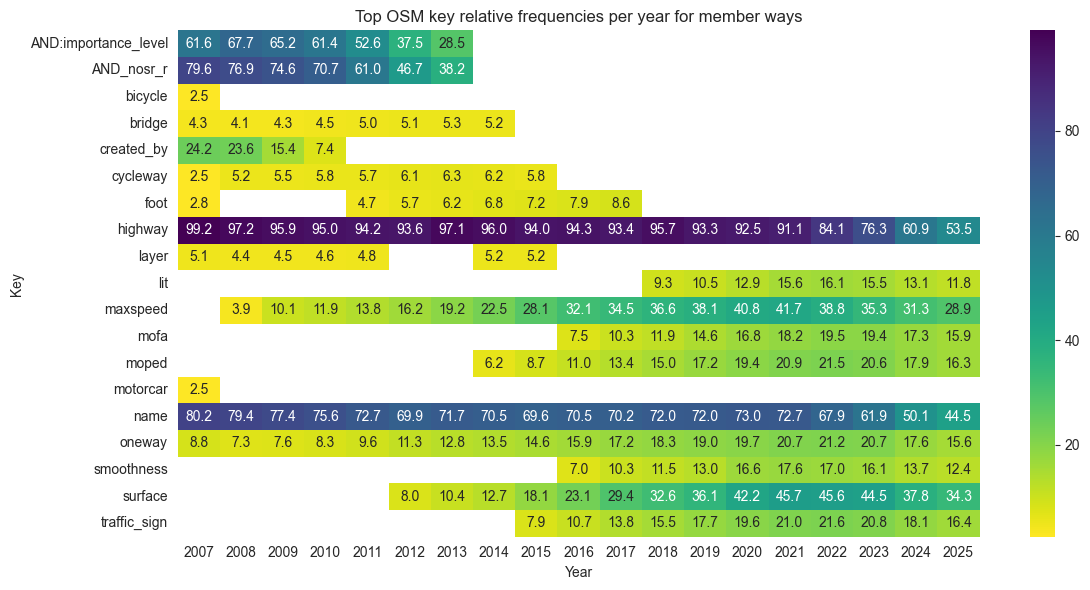

In [140]:
df = duckdb.sql("""
--Calculate relative frequencies for each key year. 
--Then rank keys within each year and and kep the 5 most frequent ones.
WITH key_frequencies_per_year AS (
    SELECT
        year,
        key,
        COUNT(*) as absolute_frequency,
        COUNT(*) * 100.0 /total_ways AS relative_frequency
    FROM brm_ways_unnested_tags
    JOIN rm_total_ways USING (year) --join total number of ways per year
    GROUP BY year, key, total_ways
) 
SELECT * 
FROM key_frequencies_per_year
QUALIFY RANK() OVER (PARTITION BY year ORDER BY relative_frequency DESC) <= 10
ORDER BY year ASC, relative_frequency DESC;
""").df()

#Prepare the data for visualization
heatmap_df = df.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="viridis_r")
plt.title("Top OSM key relative frequencies per year for member ways")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()

## Share of cycling infrastructure types for bicycle relation member ways by year

The query classifies **relation member ways** into several bicycle-infrastructure categories based on their OSM tags. These categories represent different types of cycling environments that appear along bicycle routes:

1. **Lane (dedicated cycle lane, painted lane on the road)**

Cyclists have their **own lane**, painted or marked on the road surface.
Identified via:
- cycleway=lane
- cycleway:right=lane
- cycleway:left=lane
- cycleway:both=lane

2. **Shared lane (no dedicated space for bicycles)**

Cyclists ride **on the main carriageway**, sharing space with motor vehicles.
Identified via:
- cycleway=shared_lane
- cycleway:right=shared_lane
- cycleway:left=shared_lane
- cycleway:both=shared_lane

This reflects streets where cycling is allowed but not separated from traffic

3. **Shared busway**

Cyclists share a **bus lane**, often safer than mixing with general traffic.
Identified via:
- cycleway=share_busway
- cycleway:right=share_busway
- cycleway:left=share_busway
- cycleway:both=share_busway

4. **No Infrastructure**

The road is **open to cycling** but has **no dedicated infrastructure**.
Identified via:
- cycleway=no
- cycleway:right=no
- cycleway:left=no
- cycleway:both=no

This typically corresponds to regular streets where bicycles are simply permitted.

5. **Separated (separated infrastructure, physically protected or fully independent)**

Identified via either:
- cycleway=track (cycleway:right=track, cycleway:left=track, cycleway:both=track)
- or a fully separate geometry: highway=cycleway

This represents the **strongest form of bicycle protection.**

6. **Cycle-only road**

Roads where motor traffic is restricted and cycling has priority.
Identified via:
- cyclestreet=yes
- bicycle_road=yes

These streets are designed specifically for bicycle priority or exclusive access.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

year  total_rm_ways  total_lane_combined  percentage_lane_combined  \
0   2007            886                  0.0                  0.000000   
1   2008          33380                515.0                  1.542840   
2   2009          54888               1013.0                  1.845576   
3   2010          84174               1868.0                  2.219213   
4   2011         108816               2803.0                  2.575908   
5   2012         122165               3977.0                  3.255433   
6   2013         131703               4314.0                  3.275552   
7   2014         135928               4552.0                  3.348832   
8   2015         139295               4942.0                  3.547866   
9   2016         143257               5302.0                  3.701041   
10  2017         148130               5779.0                  3.901303   
11  2018         148879               5803.0                  3.897796   
12  2019         149458               5925.0                  3.964324   
13  2020         147258               5869.0                  3.985522   
14  2021         139868               5833.0                  4.170361   
15  2022         121584               5377.0                  4.422457   
16  2023          94364               4102.0                  4.346997   
17  2024          55973               2560.0                  4.573634   
18  2025          22147               1208.0                  5.454463   

    total_shared_lane_combined  percentage_shared_lane_combined  \
0                          0.0                         0.000000   
1                          0.0                         0.000000   
2                          0.0                         0.000000   
3                          2.0                         0.002376   
4                         35.0                         0.032164   
5                        279.0                         0.228380   
6                        632.0                         0.479868   
7                        902.0                         0.663587   
8                        995.0                         0.714311   
9                       1231.0                         0.859295   
10                      1608.0                         1.085533   
11                      1766.0                         1.186198   
12                      2004.0                         1.340845   
13                      2504.0                         1.700417   
14                      2714.0                         1.940401   
15                      2550.0                         2.097315   
16                      2152.0                         2.280531   
17                      1478.0                         2.640559   
18                       699.0                         3.156184   

    total_share_busway_combined  percentage_share_busway_combined  \
0                           0.0                          0.000000   
1                           0.0                          0.000000   
2                           0.0                          0.000000   
3                           0.0                          0.000000   
4                           0.0                          0.000000   
5                           2.0                          0.001637   
6                           2.0                          0.001519   
7                           2.0                          0.001471   
8                           2.0                          0.001436   
9                           1.0                          0.000698   
10                          2.0                          0.001350   
11                          1.0                          0.000672   
12                          0.0                          0.000000   
13                          0.0                          0.000000   
14                          0.0                          0.000000   
15                          0.0                          0.000000   
16       

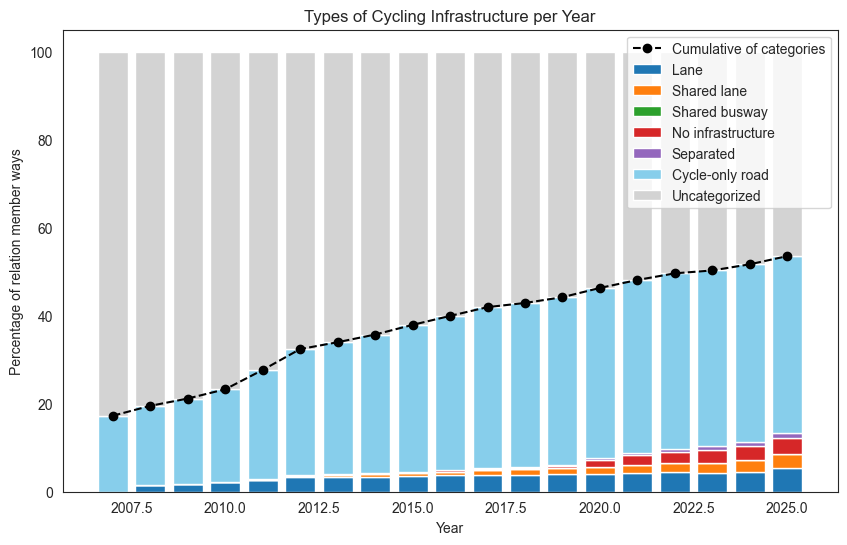

In [153]:
df = duckdb.sql("""
--##Goal: Determine infrastruction type of relation member ways. Share of infrastructure related tags relative to total number of relation member ways
SELECT year,
    --Total number of relation member ways for each year
    COUNT(*) AS total_rm_ways,

    --Count ways where cycleway(*)=lane and calculate relative frequency as a percentage of all relation member ways for each year
    COUNT_IF(map_contains_entry(tags, 'cycleway','lane') OR map_contains_entry(tags, 'cycleway:right','lane') OR map_contains_entry(tags, 'cycleway:left','lane') OR map_contains_entry(tags, 'cycleway:both','lane')) AS total_lane_combined,
    COUNT_IF(map_contains_entry(tags, 'cycleway','lane') OR map_contains_entry(tags, 'cycleway:right','lane') OR map_contains_entry(tags, 'cycleway:left','lane') OR map_contains_entry(tags, 'cycleway:both','lane')) * 100.0 / COUNT(*) AS percentage_lane_combined,   

    --Count ways where cycleway(*)=shared_lane and calculate relative frequency as a percentage of all relation member ways for each year
    COUNT_IF(map_contains_entry(tags, 'cycleway','shared_lane') OR map_contains_entry(tags, 'cycleway:right','shared_lane') OR map_contains_entry(tags, 'cycleway:left','shared_lane') OR map_contains_entry(tags, 'cycleway:both','shared_lane')) AS total_shared_lane_combined,
    COUNT_IF(map_contains_entry(tags, 'cycleway','shared_lane') OR map_contains_entry(tags, 'cycleway:right','shared_lane') OR map_contains_entry(tags, 'cycleway:left','shared_lane') OR map_contains_entry(tags, 'cycleway:both','shared_lane')) * 100.0 / COUNT(*) AS percentage_shared_lane_combined,   

    --Count ways where cycleway(*)=share_busway and calculate relative frequency as a percentage of all relation member ways for each year
    COUNT_IF(map_contains_entry(tags, 'cycleway','share_busway') OR map_contains_entry(tags, 'cycleway:right','share_busway') OR map_contains_entry(tags, 'cycleway:left','share_busway') OR map_contains_entry(tags, 'cycleway:both','share_busway')) AS total_share_busway_combined,
    COUNT_IF(map_contains_entry(tags, 'cycleway','share_busway') OR map_contains_entry(tags, 'cycleway:right','share_busway') OR map_contains_entry(tags, 'cycleway:left','share_busway') OR map_contains_entry(tags, 'cycleway:both','share_busway')) * 100.0 / COUNT(*) AS percentage_share_busway_combined,   

    --Count ways where cycleway(*)=no and calculate relative frequency as a percentage of all relation member ways for each year
    COUNT_IF(map_contains_entry(tags, 'cycleway','no') OR map_contains_entry(tags, 'cycleway:right','no') OR map_contains_entry(tags, 'cycleway:left','no') OR map_contains_entry(tags, 'cycleway:both','no')) AS total_no_infrastructure_combined,
    COUNT_IF(map_contains_entry(tags, 'cycleway','no') OR map_contains_entry(tags, 'cycleway:right','no') OR map_contains_entry(tags, 'cycleway:left','no') OR map_contains_entry(tags, 'cycleway:both','no')) * 100.0 / COUNT(*) AS percentage_no_infrastructure_combined, 

    --Count ways where cycleway(*)=track AND highway=cycleway and calculate relative frequency as a percentage of all relation member ways for each year
    COUNT_IF(map_contains_entry(tags, 'highway','cycleway') OR map_contains_entry(tags, 'cycleway','track') OR map_contains_entry(tags, 'cycleway:right', 'track') OR map_contains_entry(tags, 'cycleway:left', 'track') OR map_contains_entry(tags, 'cycleway:both', 'track')) AS total_separated_combined,
    COUNT_IF(map_contains_entry(tags, 'highway','cycleway') OR map_contains_entry(tags, 'cycleway','track') OR map_contains_entry(tags, 'cycleway:right', 'track') OR map_contains_entry(tags, 'cycleway:left', 'track') OR map_contains_entry(tags, 'cycleway:both', 'track'))* 100.0 / COUNT(*) AS percentage_separated_combined,

    --Count ways where cycleway(*)=track AND highway=cycleway and calculate relative frequency as a percentage of all relation member ways for each year
    COUNT_IF(map_contains_entry(tags, 'cyclestreet', 'yes') OR map_contains_entry(tags, 'bicycle_road','yes')) AS total_cyclestreet_combined,
    COUNT_IF(map_contains_entry(tags, 'cyclestreet', 'yes') OR map_contains_entry(tags, 'bicycle_road','yes'))* 100.0 / COUNT(*) AS percentage_cyclestreet_combined

FROM persistent_db.rm_from_relations_latest_valid_to --Table of ways in bicycle relations (type=bicycle AND route=bicycle)
GROUP BY year; --Group by year
""").df()

# Compute cumulative coverage of the categories
df['cumulative'] = df['percentage_lane_combined'] + df['percentage_shared_lane_combined'] + df['percentage_share_busway_combined'] + df['percentage_no_infrastructure_combined'] + df['percentage_separated_combined'] + df['percentage_cyclestreet_combined']
df['uncategorized'] = 100 - df['cumulative']

display(df)

# Plot
fig, ax = plt.subplots(figsize=(10,6))

# Stacked bar chart for infrastructure types
# Plot each category
ax.bar(df['year'], df['percentage_lane_combined'], label='Lane')
ax.bar(df['year'], df['percentage_shared_lane_combined'], bottom=df['percentage_lane_combined'], label='Shared lane')
ax.bar(df['year'], df['percentage_share_busway_combined'], bottom=df['percentage_lane_combined'] + df['percentage_shared_lane_combined'], label='Shared busway')
ax.bar(df['year'], df['percentage_no_infrastructure_combined'], bottom=df['percentage_lane_combined'] + df['percentage_shared_lane_combined'] + df['percentage_share_busway_combined'], label='No infrastructure')
ax.bar(df['year'], df['percentage_cyclestreet_combined'], bottom=df['percentage_lane_combined'] + df['percentage_shared_lane_combined'] + df['percentage_share_busway_combined'] + df['percentage_no_infrastructure_combined'], label='Separated')
ax.bar(df['year'], df['percentage_separated_combined'], bottom=df['percentage_lane_combined'] + df['percentage_shared_lane_combined'] + df['percentage_share_busway_combined'] + df['percentage_no_infrastructure_combined'] + df['percentage_cyclestreet_combined'], label='Cycle-only road', color='skyblue')
#Include untagged category
ax.bar(df['year'], df['uncategorized'], bottom=df['cumulative'], color='lightgrey', label='Uncategorized')

# Overlay cumulative line
ax.plot(df['year'], df['cumulative'], color='black', marker='o', linestyle='--', label='Cumulative of categories')

ax.set_xlabel('Year')
ax.set_ylabel('Percentage of relation member ways')
ax.set_title('Types of Cycling Infrastructure per Year')
ax.legend()
plt.show()

## Zoomed in: exploration composition of "separated" infrastructure category

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

year  total_rm_ways  total_highway_cycleway  \
0   2007            886                   148.0   
1   2008          33380                  5728.0   
2   2009          54888                 10164.0   
3   2010          84174                 17069.0   
4   2011         108816                 26318.0   
5   2012         122165                 34276.0   
6   2013         131703                 38598.0   
7   2014         135928                 41848.0   
8   2015         139295                 45782.0   
9   2016         143257                 49614.0   
10  2017         148130                 53599.0   
11  2018         148879                 55015.0   
12  2019         149458                 56438.0   
13  2020         147258                 56528.0   
14  2021         139868                 54534.0   
15  2022         121584                 48197.0   
16  2023          94364                 37481.0   
17  2024          55973                 22387.0   
18  2025          22147                  8823.0   

    percentage_of_highway_cycleway  cycleway_track  cycleway_right_track  \
0                        16.704289            20.0                   0.0   
1                        17.159976          1113.0                   0.0   
2                        18.517709          1757.0                   0.0   
3                        20.278233          2454.0                   0.0   
4                        24.185782          2492.0                  15.0   
5                        28.057136          1966.0                  24.0   
6                        29.306850          1728.0                  30.0   
7                        30.786887          1416.0                  40.0   
8                        32.866937           879.0                  48.0   
9                        34.632863           684.0                  53.0   
10                       36.183758           591.0                  58.0   
11                       36.952827           520.0                  53.0   
12                       37.761779           359.0                  65.0   
13                       38.387049           308.0                  96.0   
14                       38.989619           267.0                  77.0   
15                       39.640907           197.0                  85.0   
16                       39.719596           112.0                  69.0   
17                       39.996070            62.0                  54.0   
18                       39.838353            24.0                  22.0   

    cycleway_left_track  cycleway_both_track  total_track_combined  \
0                   0.0                  0.0                  20.0   
1                   0.0                  0.0                1113.0   
2                   0.0                  0.0                1757.0   
3                   0.0                  0.0                2454.0   
4                  28.0                  0.0                2534.0   
5                  20.0                  0.0                2009.0   
6                  28.0                  2.0                1787.0   
7                  42.0                  2.0                1498.0   
8                  27.0                  2.0                 954.0   
9                  18.0                  2.0                 755.0   
10                 21.0                  3.0                 671.0   
11                 19.0                  3.0                 593.0   
12                 15.0                  6.0                 443.0   
13                  8.0                 31.0                 443.0   
14                 11.0                 74.0                 428.0   
15                 18.0                 72.0                 370.0   
16                 17.0                 53.0                 250.0   
17                 11.0                 38.0                 163.0   
18                  2.0                 21.0                  69.0   

    percentage_track_combined  cumulative  
0                

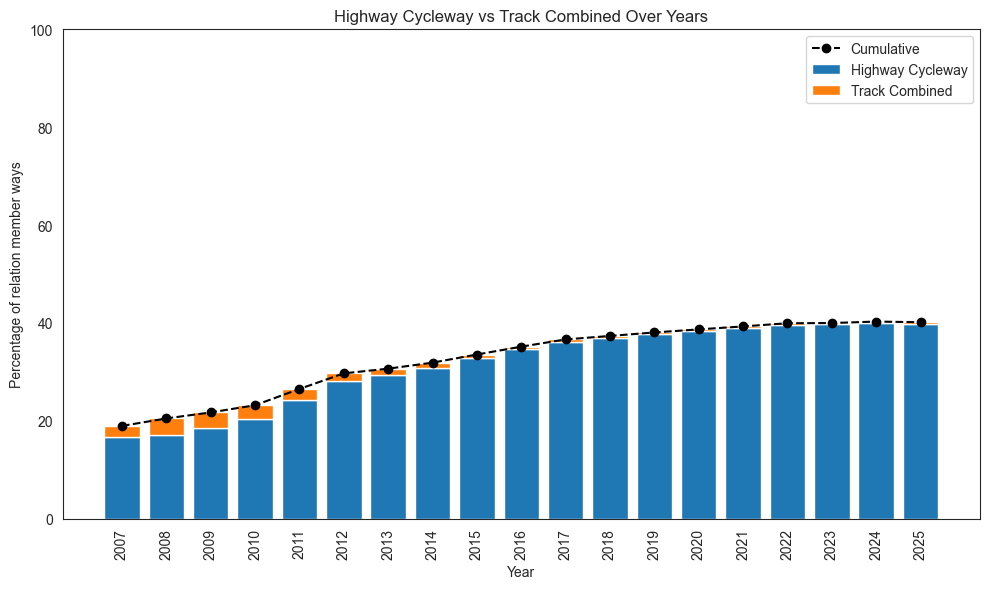

In [149]:
df = duckdb.sql("""
--##Goal: Determine the share of ways tagged with highway='cycleway' vs cycleway(*)='track'
SELECT year, 
    --Total number of relation member ways for each year
    COUNT(*) AS total_rm_ways,

    --Count ways where highway=cycleway and calculate relative frequency as percentage of all relation member ways for each year
    COUNT_IF(map_contains_entry(tags, 'highway','cycleway')) AS total_highway_cycleway,
    COUNT_IF(map_contains_entry(tags, 'highway','cycleway')) * 100.0 / COUNT(*) AS percentage_of_highway_cycleway,

    --Count ways where
    COUNT_IF(map_contains_entry(tags, 'cycleway','track')) AS cycleway_track,
    COUNT_IF(map_contains_entry(tags, 'cycleway:right', 'track')) AS cycleway_right_track,
    COUNT_IF(map_contains_entry(tags, 'cycleway:left', 'track')) AS cycleway_left_track,
    COUNT_IF(map_contains_entry(tags, 'cycleway:both', 'track')) AS cycleway_both_track,

    --Count any way that has at least one of the following: 
    --cycleway=track OR cycleway:right=track OR cycleway:left=track OR cycleway:both=track
    --If a row has multiple tags (cycleway, cycleway:right, cycleway:left, cycleway:both), it is counted only once. This is intentional, one way should be counted only once regardless of tag detail
    COUNT_IF(map_contains_entry(tags, 'cycleway','track') OR map_contains_entry(tags, 'cycleway:right', 'track') OR map_contains_entry(tags, 'cycleway:left', 'track') OR map_contains_entry(tags, 'cycleway:both', 'track')) AS total_track_combined,
    COUNT_IF(map_contains_entry(tags, 'cycleway','track') OR map_contains_entry(tags, 'cycleway:right', 'track') OR map_contains_entry(tags, 'cycleway:left', 'track') OR map_contains_entry(tags, 'cycleway:both', 'track'))* 100.0 / COUNT(*) AS percentage_track_combined

FROM persistent_db.rm_from_relations_latest_valid_to --Table of ways in bicycle relations (type=bicycle ANd route=bicycle)
GROUP BY year; --Group by year
""").df()

# Compute cumulative, which represents category: separated
df['cumulative'] = df['percentage_of_highway_cycleway'] + df['percentage_track_combined']

display(df)

# Plot
fig, ax = plt.subplots(figsize=(10,6))

# Stacked bar chart
ax.bar(df['year'], df['percentage_of_highway_cycleway'], label='Highway Cycleway')
ax.bar(df['year'], df['percentage_track_combined'], bottom=df['percentage_of_highway_cycleway'], label='Track Combined')

# Overlay cumulative line
ax.plot(df['year'], df['cumulative'], color='black', marker='o', linestyle='--', label='Cumulative')

# X-axis formatting
ax.set_xticks(df['year'])
ax.set_xticklabels(df['year'], rotation=90) 

#Force y-axis to reach 100% -So to meke it clear that category=separated still makes up a small part of all relation member ways
ax.set_ylim(0, 100)

# Labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Percentage of relation member ways')
ax.set_title('Highway Cycleway vs Track Combined Over Years')
ax.legend()
plt.tight_layout()
plt.show()

In [152]:
df = duckdb.sql("""
CREATE OR REPLACE MACRO cycle_analysis(filter_condition) AS TABLE (
    WITH rm_ways_unnested_tags_filtered AS (
        SELECT year, UNNEST(map_entries(tags), recursive := true)
        FROM persistent_db.rm_from_relations_latest_valid_to
        WHERE filter_condition
    ),
    total_rm_ways_filtered AS (
        SELECT year, COUNT(*) as rm_total_ways_filtered
        FROM persistent_db.rm_from_relations_latest_valid_to
        WHERE filter_condition
        GROUP BY year
    ),
    key_frequencies_per_year AS (
        SELECT
            year,
            key,
            COUNT(*) AS absolute_frequency,
            COUNT(*) * 100.0 / rm_total_ways_filtered AS relative_frequency
        FROM rm_ways_unnested_tags_filtered
        JOIN total_rm_ways_filtered USING (year)
        GROUP BY year, key, rm_total_ways_filtered
    )
    SELECT *
    FROM key_frequencies_per_year
    QUALIFY RANK() OVER (PARTITION BY year ORDER BY relative_frequency DESC) <= 10
    ORDER BY year ASC, relative_frequency DESC
);
""")


#Category 1: Cycle lanes 
df_cycle_lane = duckdb.sql("""
SELECT * FROM cycle_analysis(
    map_contains_entry(tags, 'cycleway', 'lane')
    OR map_contains_entry(tags, 'cycleway:right', 'lane')
    OR map_contains_entry(tags, 'cycleway:left', 'lane')
    OR map_contains_entry(tags, 'cycleway:both', 'lane')
);
""").df()

#Category 2: Shared lanes 
df_shared_lane = duckdb.sql("""
SELECT * FROM cycle_analysis(
    map_contains_entry(tags, 'cycleway', 'shared_lane')
    OR map_contains_entry(tags, 'cycleway:right', 'shared_lane')
    OR map_contains_entry(tags, 'cycleway:left', 'shared_lane')
    OR map_contains_entry(tags, 'cycleway:both', 'shared_lane')
);
""").df()

#Category 3: Share Busway
df_share_busway = duckdb.sql("""
SELECT * FROM cycle_analysis(
    map_contains_entry(tags, 'cycleway', 'share_busway')
    OR map_contains_entry(tags, 'cycleway:right', 'share_busway')
    OR map_contains_entry(tags, 'cycleway:left', 'share_busway')
    OR map_contains_entry(tags, 'cycleway:both', 'share_busway')
);
""").df()

#Category 4: No Infrastructure 
df_no_infrastructure = duckdb.sql("""
SELECT * FROM cycle_analysis(
    map_contains_entry(tags, 'cycleway', 'no')
    OR map_contains_entry(tags, 'cycleway:right', 'no')
    OR map_contains_entry(tags, 'cycleway:left', 'no')
    OR map_contains_entry(tags, 'cycleway:both', 'no')
);
""").df()


#Category 5: Separated - Independent cycle paths 
df_independent = duckdb.sql("""
SELECT * FROM cycle_analysis(
    map_contains_entry(tags, 'highway', 'cycleway')

);
""").df()

#Category 5: Separated - Cycle tracks 
df_cycle_tracks = duckdb.sql("""
SELECT * FROM cycle_analysis(
    map_contains_entry(tags, 'cycleway', 'track')
    OR map_contains_entry(tags, 'cycleway:right', 'track')
    OR map_contains_entry(tags, 'cycleway:left', 'track')
    OR map_contains_entry(tags, 'cycleway:both', 'track')
);
""").df()

#Category 6: Cycle-only roads
df_cyclestreet = duckdb.sql("""
SELECT * FROM cycle_analysis(
    map_contains_entry(tags, 'highway', 'cyclestreet')
    OR map_contains_entry(tags, 'bicycle_road', 'yes')
);
""").df()


#Category 7: Other
df_other = duckdb.sql("""
SELECT * FROM cycle_analysis(
    NOT map_contains_entry(tags, 'cycleway', 'lane')
    AND NOT map_contains_entry(tags, 'cycleway:right', 'lane')
    AND NOT map_contains_entry(tags, 'cycleway:left', 'lane')
    AND NOT map_contains_entry(tags, 'cycleway:both', 'lane')
    AND NOT map_contains_entry(tags, 'cycleway', 'shared_lane')
    AND NOT map_contains_entry(tags, 'cycleway:right', 'shared_lane')
    AND NOT map_contains_entry(tags, 'cycleway:left', 'shared_lane')
    AND NOT map_contains_entry(tags, 'cycleway:both', 'shared_lane')
    AND NOT map_contains_entry(tags, 'highway', 'cycleway')
    AND NOT map_contains_entry(tags, 'highway', 'cyclestreet')
    AND NOT map_contains_entry(tags, 'bicycle_road', 'yes')
    AND NOT map_contains_entry(tags, 'cycleway', 'track')
    AND NOT map_contains_entry(tags, 'cycleway:right', 'track')
    AND NOT map_contains_entry(tags, 'cycleway:left', 'track')
    AND NOT map_contains_entry(tags, 'cycleway:both', 'track')
);
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

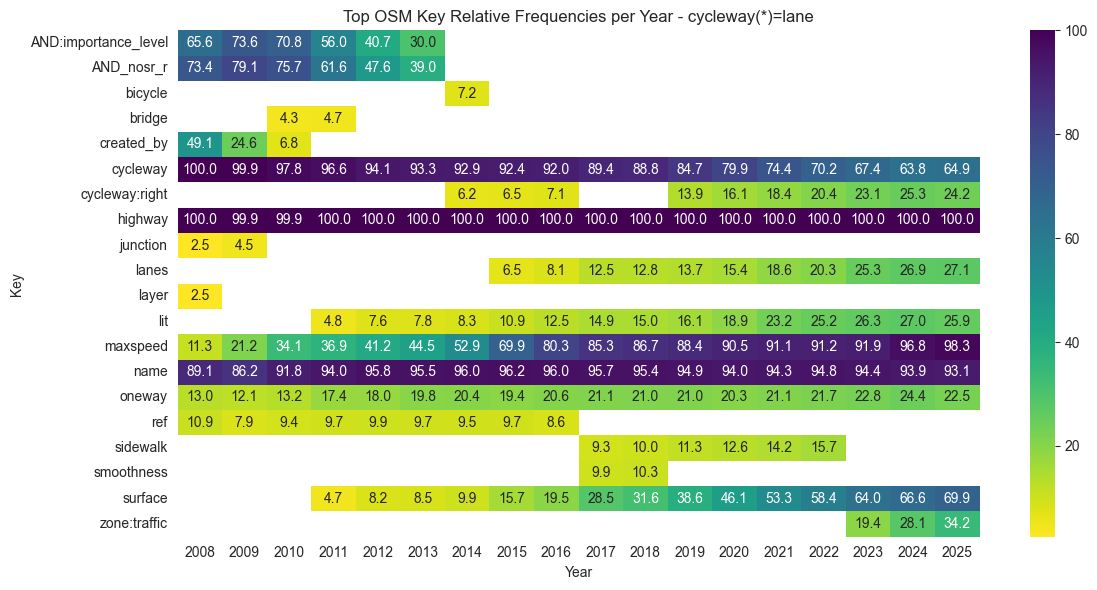

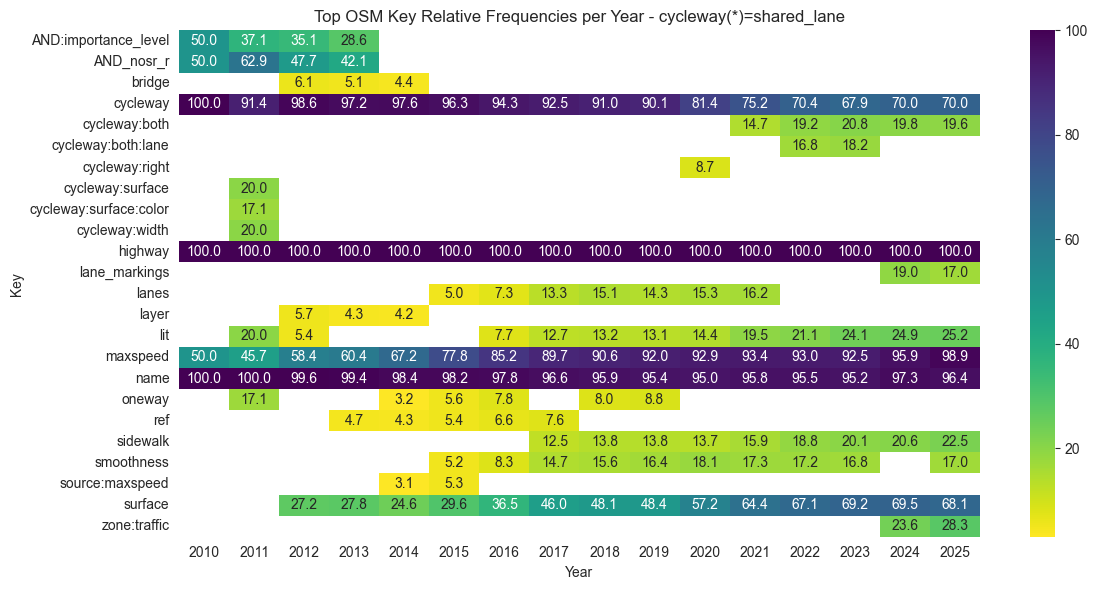

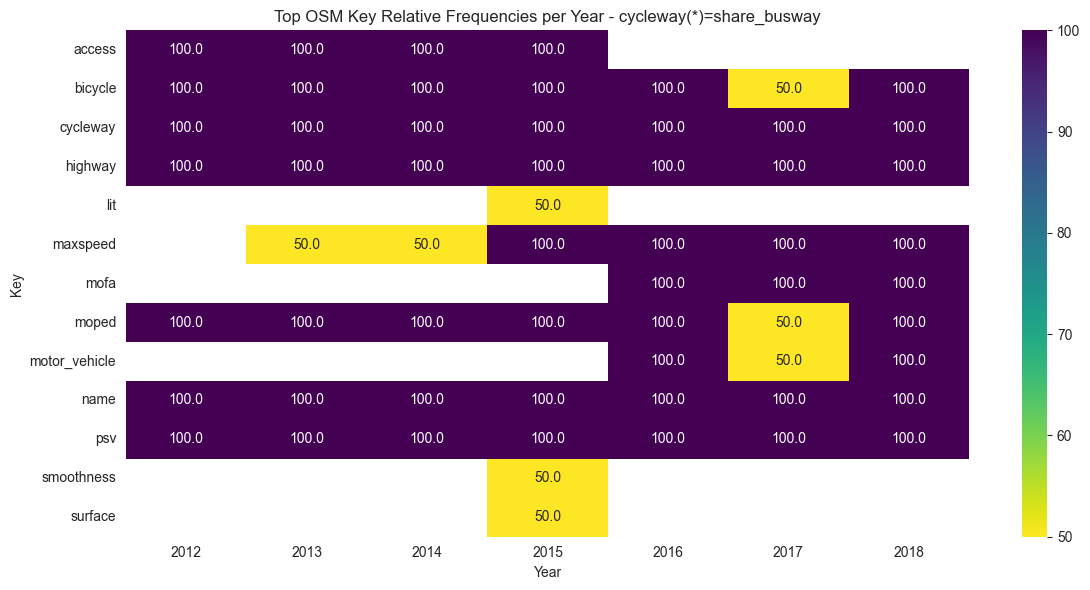

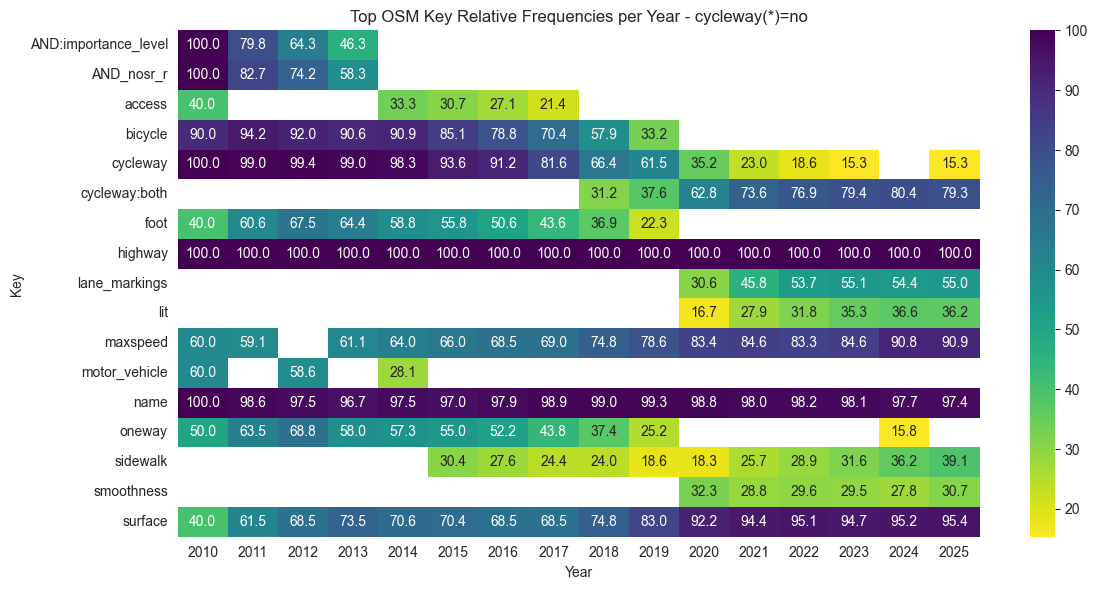

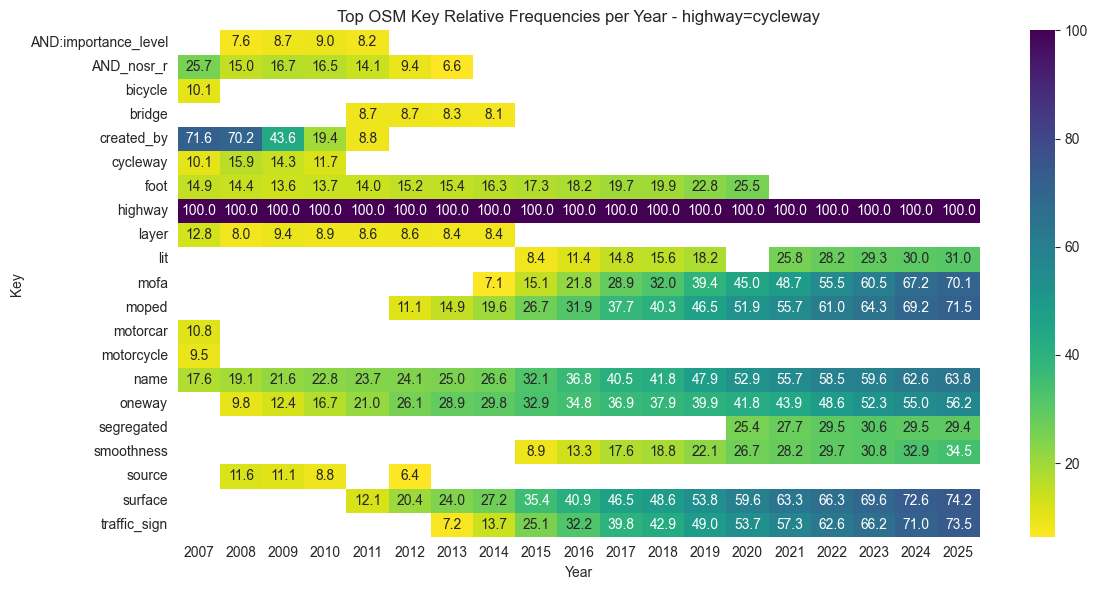

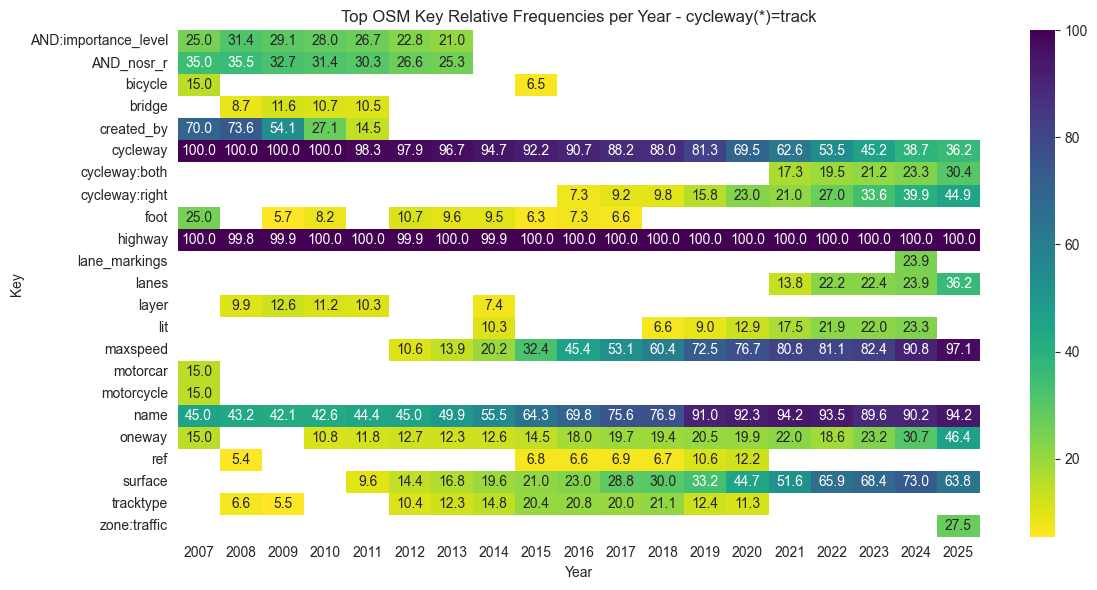

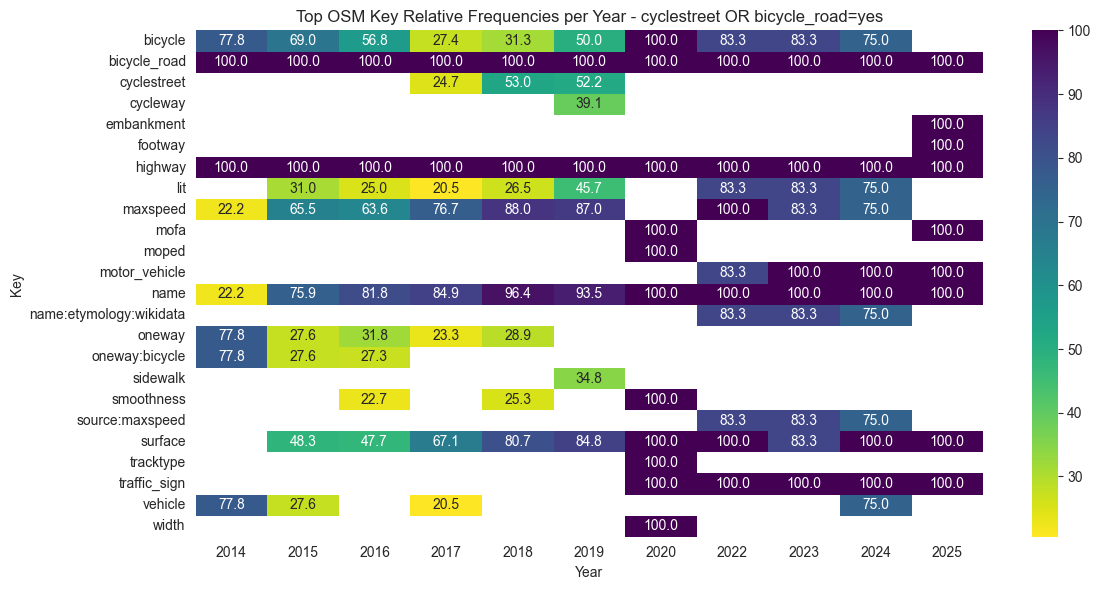

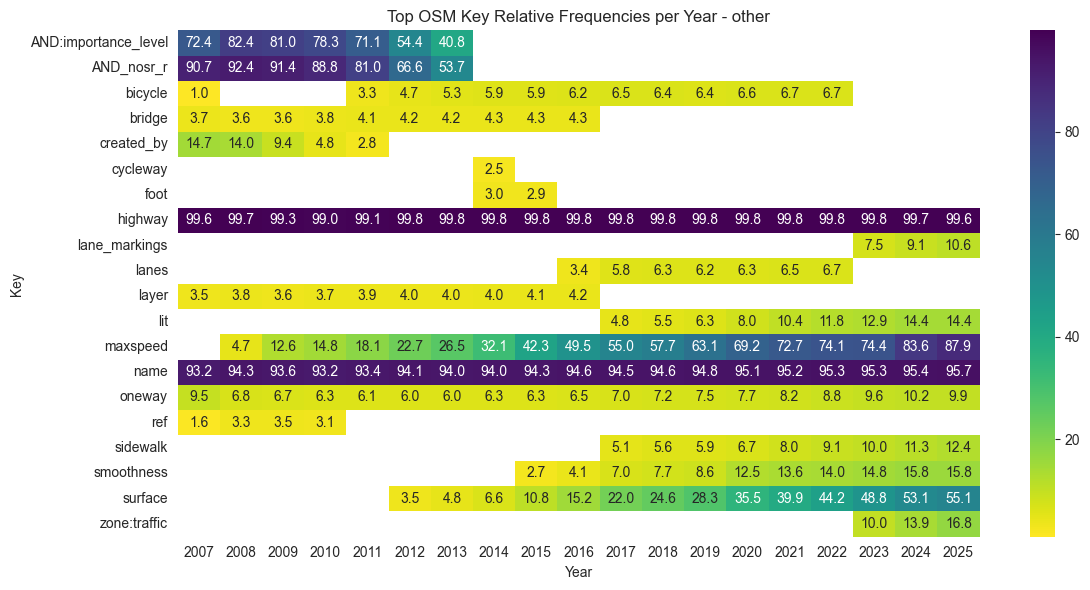

In [156]:
#Category 1
heatmap_df = df_cycle_lane.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="viridis_r")
plt.title("Top OSM Key Relative Frequencies per Year - cycleway(*)=lane")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()

#Category 2
heatmap_df = df_shared_lane.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="viridis_r")
plt.title("Top OSM Key Relative Frequencies per Year - cycleway(*)=shared_lane")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()

#Category 3
heatmap_df = df_share_busway.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="viridis_r")
plt.title("Top OSM Key Relative Frequencies per Year - cycleway(*)=share_busway")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()

#Category 4: 
heatmap_df = df_no_infrastructure.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="viridis_r")
plt.title("Top OSM Key Relative Frequencies per Year - cycleway(*)=no")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()


#Category 5: Highway=cyclway
heatmap_df = df_independent.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="viridis_r")
plt.title("Top OSM Key Relative Frequencies per Year - highway=cycleway")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()

#Category 5: Cycle tracks
heatmap_df = df_cycle_tracks.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="viridis_r")
plt.title("Top OSM Key Relative Frequencies per Year - cycleway(*)=track")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()

#Category 6
heatmap_df = df_cyclestreet.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="viridis_r")
plt.title("Top OSM Key Relative Frequencies per Year - cyclestreet OR bicycle_road=yes")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()

#Category 7
heatmap_df = df_other.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="viridis_r")
plt.title("Top OSM Key Relative Frequencies per Year - other")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()

## Zoomed in: Top OSM tags associated with cycleway(*)=lane

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

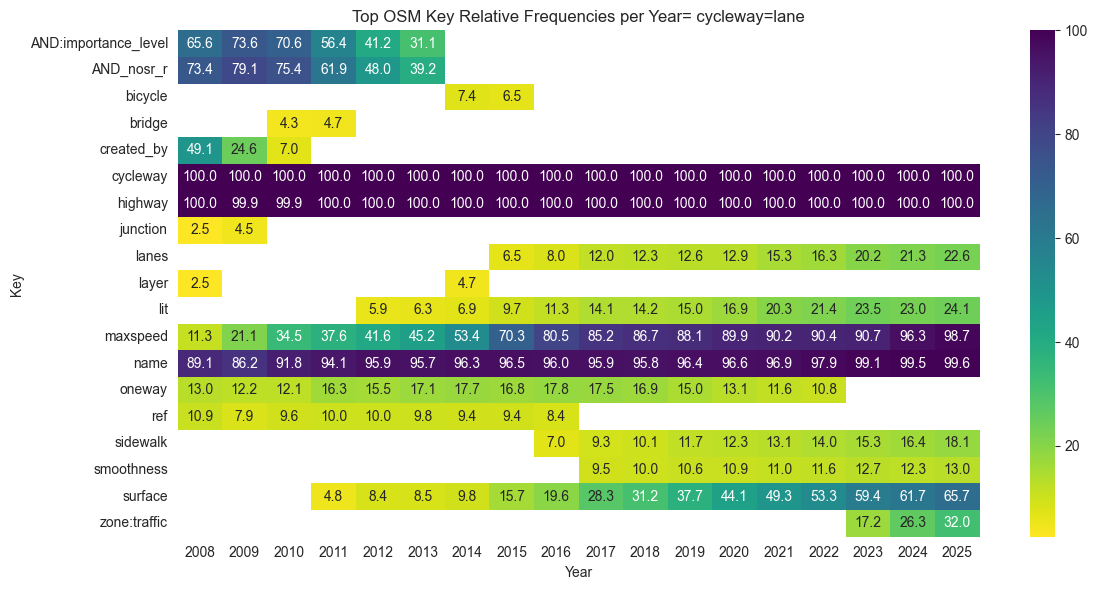

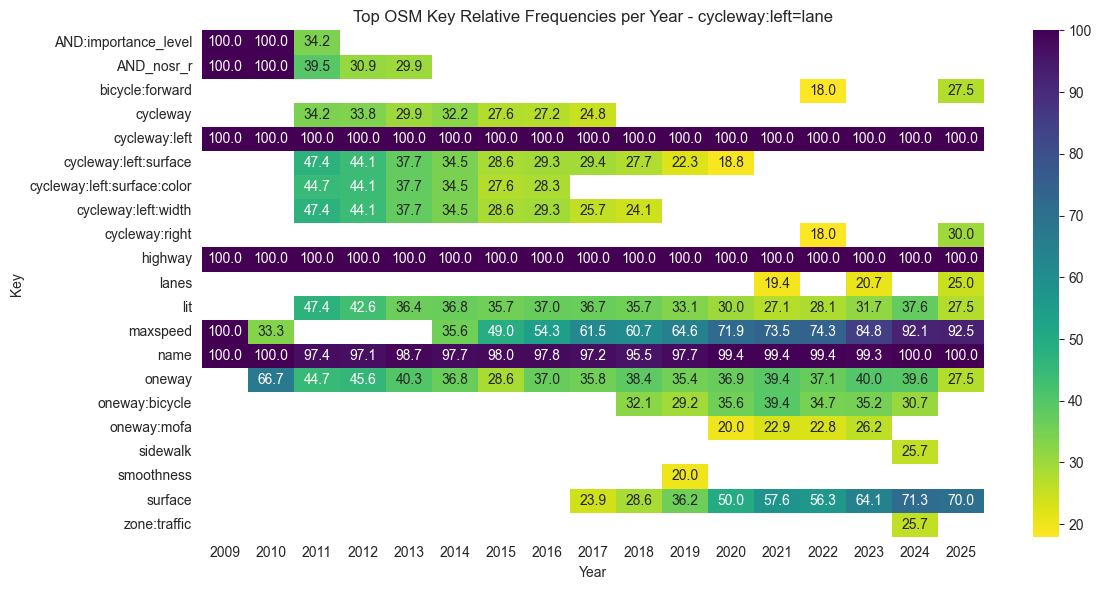

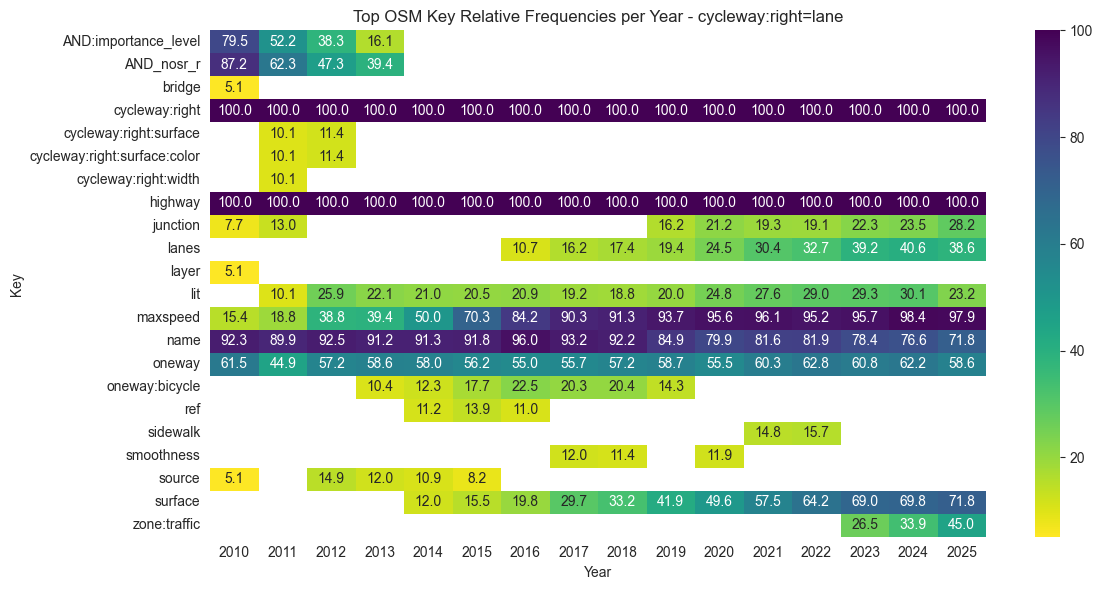

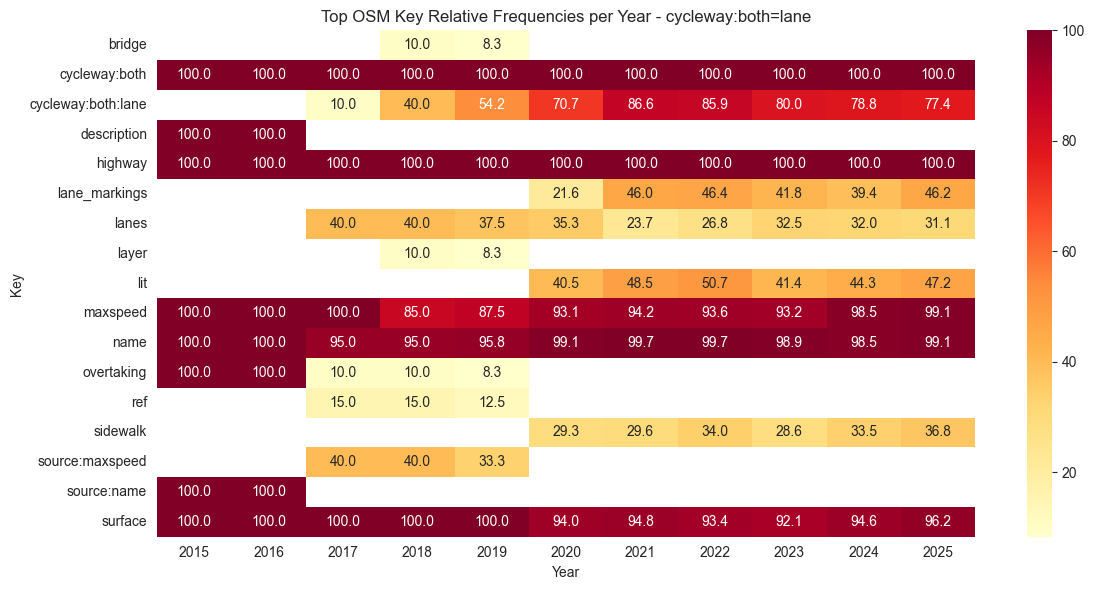

In [158]:
df = duckdb.sql("""
CREATE OR REPLACE MACRO cycle_analysis(filter_condition) AS TABLE (
    WITH rm_ways_unnested_tags_filtered AS (
        SELECT year, UNNEST(map_entries(tags), recursive := true)
        FROM persistent_db.rm_from_relations_latest_valid_to
        WHERE filter_condition
    ),
    total_rm_ways_filtered AS (
        SELECT year, COUNT(*) as rm_total_ways_filtered
        FROM persistent_db.rm_from_relations_latest_valid_to
        WHERE filter_condition
        GROUP BY year
    ),
    key_frequencies_per_year AS (
        SELECT
            year,
            key,
            COUNT(*) AS absolute_frequency,
            COUNT(*) * 100.0 / rm_total_ways_filtered AS relative_frequency
        FROM rm_ways_unnested_tags_filtered
        JOIN total_rm_ways_filtered USING (year)
        GROUP BY year, key, rm_total_ways_filtered
    )
    SELECT *
    FROM key_frequencies_per_year
    QUALIFY RANK() OVER (PARTITION BY year ORDER BY relative_frequency DESC) <= 10
    ORDER BY year ASC, relative_frequency DESC
);
""")


#Category 1: Cycle lanes 
df_cycle_lane_no_direction = duckdb.sql("""
SELECT * FROM cycle_analysis(
    map_contains_entry(tags, 'cycleway', 'lane')
);
""").df()

df_cycle_lane_right = duckdb.sql("""
SELECT * FROM cycle_analysis(
    map_contains_entry(tags, 'cycleway:right', 'lane')
);
""").df()

df_cycle_lane_left = duckdb.sql("""
SELECT * FROM cycle_analysis(
    map_contains_entry(tags, 'cycleway:left', 'lane')
);
""").df()

df_cycle_lane_both = duckdb.sql("""
SELECT * FROM cycle_analysis(
    map_contains_entry(tags, 'cycleway:both', 'lane')
);
""").df()

#Plot heatmap for each caegory 

heatmap_df = df_cycle_lane_no_direction.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="viridis_r")
plt.title("Top OSM Key Relative Frequencies per Year= cycleway=lane")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()


heatmap_df = df_cycle_lane_left.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="viridis_r")
plt.title("Top OSM Key Relative Frequencies per Year - cycleway:left=lane")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()


heatmap_df = df_cycle_lane_right.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="viridis_r")
plt.title("Top OSM Key Relative Frequencies per Year - cycleway:right=lane")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()

heatmap_df = df_cycle_lane_both.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Top OSM Key Relative Frequencies per Year - cycleway:both=lane")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()

# DELETE? No time

In [13]:
#Creation temporary table: Total number of ways outside bicycle relations per year
duckdb.sql("""
CREATE OR REPLACE TEMP TABLE total_non_bicycle_ways_per_year AS
SELECT year, COUNT(*) as total_ways
FROM persistent_db.ways_not_in_rm_ways_all_until2018
WHERE map_contains_entry(tags, 'bicycle','yes')
    OR map_contains_entry(tags, 'bicycle:forward','yes')
    OR map_contains_entry(tags, 'bicycle:backward','yes')
    OR map_contains_entry(tags, 'bicycle','designated')
    OR map_contains_entry(tags, 'bicycle:forward','designated')
    OR map_contains_entry(tags, 'bicycle:backward','designated')
    OR map_contains_entry(tags, 'highway','cycleway')
    OR map_contains_entry(tags, 'cycleway','track')
    OR map_contains_entry(tags, 'cycleway:right','track')
    OR map_contains_entry(tags, 'cycleway:left','track')
    OR map_contains_entry(tags, 'cycleway:both','track')
    OR map_contains_entry(tags, 'cycleway','lane')
    OR map_contains_entry(tags, 'cycleway:right','lane')
    OR map_contains_entry(tags, 'cycleway:left','lane')
    OR map_contains_entry(tags, 'cycleway:both','lane')
    OR map_contains_entry(tags, 'cycleway','shared_lane')
    OR map_contains_entry(tags, 'cycleway:right','shared_lane')
    OR map_contains_entry(tags, 'cycleway:left','shared_lane')
    OR map_contains_entry(tags, 'cycleway:both','shared_lane')
    OR map_contains_entry(tags, 'cycleway','share_busway')
    OR map_contains_entry(tags, 'cycleway:right','share_busway')
    OR map_contains_entry(tags, 'cycleway:left','share_busway')
    OR map_contains_entry(tags, 'cycleway:both','share_busway')
GROUP BY year
""")

#Creation of materialized view: Unnest tags for ways outside bicycle relations
duckdb.sql("""
CREATE OR REPLACE TEMP TABLE non_bicycle_ways_unnested_tags AS
SELECT *, UNNEST(map_entries(tags), recursive := true)
FROM persistent_db.ways_not_in_rm_ways_all_until2018
WHERE map_contains_entry(tags, 'bicycle','yes')
    OR map_contains_entry(tags, 'bicycle:forward','yes')
    OR map_contains_entry(tags, 'bicycle:backward','yes')
    OR map_contains_entry(tags, 'bicycle','designated')
    OR map_contains_entry(tags, 'bicycle:forward','designated')
    OR map_contains_entry(tags, 'bicycle:backward','designated')
    OR map_contains_entry(tags, 'highway','cycleway')
    OR map_contains_entry(tags, 'cycleway','track')
    OR map_contains_entry(tags, 'cycleway:right','track')
    OR map_contains_entry(tags, 'cycleway:left','track')
    OR map_contains_entry(tags, 'cycleway:both','track')
    OR map_contains_entry(tags, 'cycleway','lane')
    OR map_contains_entry(tags, 'cycleway:right','lane')
    OR map_contains_entry(tags, 'cycleway:left','lane')
    OR map_contains_entry(tags, 'cycleway:both','lane')
    OR map_contains_entry(tags, 'cycleway','shared_lane')
    OR map_contains_entry(tags, 'cycleway:right','shared_lane')
    OR map_contains_entry(tags, 'cycleway:left','shared_lane')
    OR map_contains_entry(tags, 'cycleway:both','shared_lane')
    OR map_contains_entry(tags, 'cycleway','share_busway')
    OR map_contains_entry(tags, 'cycleway:right','share_busway')
    OR map_contains_entry(tags, 'cycleway:left','share_busway')
    OR map_contains_entry(tags, 'cycleway:both','share_busway');
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

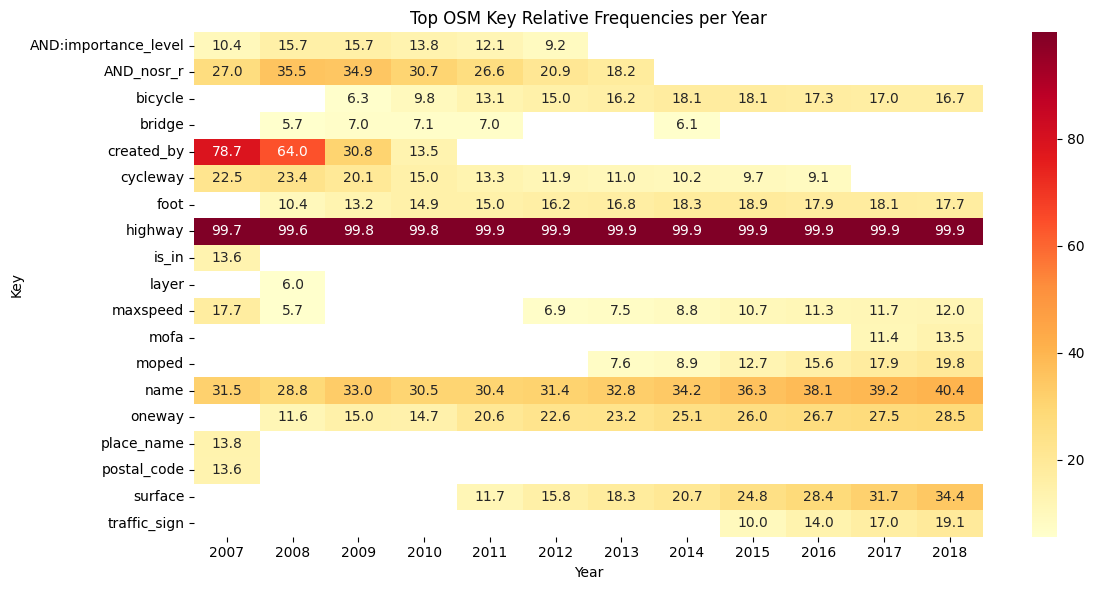

In [14]:
df = duckdb.sql("""
--Calculate relative frequencies for each key year. 
--Then rank keys within each year and and kep the 10 most frequent ones.
WITH key_frequencies_per_year AS (
    SELECT
        year,
        key,
        COUNT(*) as absolute_frequency,
        COUNT(*) * 100.0 /total_ways AS relative_frequency
    FROM non_bicycle_ways_unnested_tags
    JOIN total_non_bicycle_ways_per_year USING (year) --join total number of ways per year
    GROUP BY year, key, total_ways
) 
SELECT * 
FROM key_frequencies_per_year
QUALIFY RANK() OVER (PARTITION BY year ORDER BY relative_frequency DESC) <= 10
ORDER BY year ASC, relative_frequency DESC;
""").df()

# Pivot to heatmap shape
heatmap_df = df.pivot(index="key", columns="year", values="relative_frequency")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Top OSM Key Relative Frequencies per Year")
plt.xlabel("Year")
plt.ylabel("Key")
plt.tight_layout()
plt.show()